<a href="https://colab.research.google.com/github/davidklhui/data-analysis/blob/main/Time_Series_Analysis_(1)_ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrate the use of ARIMA model using Python, including the exploratory analysis, model building, model diagnoses, evaluation, and prediction

# Introduction

Time Series Analysis is a category of statistics that focus on analyzing the time dependent data. Time series data always exhabiting correlation, where the order of the data are important.

There are many developed methods to analyze and predict for time series data, like
1. ARIMA (Autoregressive Integrated Moving Average), a common statistical method.
2. LSTM (Long-short term memory), a common data science method that uses Recurrent Neural Network.

In this project, we will focus on ARIMA model to analyze univariate time series data. We will analyze the same dataset using LSTM in another notebook.


# ARMA, ARIMA, and SARIMA

First define {$X_t$: t=0,1,...} be the collection of data at consecutive time t. Let $Z_t$ be white noise with mean 0 and constant variance $\sigma_Z^2$, and $Cov(Z_t$, $Z_{t-h})=0$ for all $h$ > 0; also, mean of X_t = $\mu_t$.

To use ARMA model, we need the process {$X_t} to be (weakly) **stationary**

1. $E(X_t)$ is constant $\forall$ t \\
2. $Var(X_t)$ is constant $\forall$ t \\
3. $Cov(X_t, X_{t-h})$ $\text{does not depend upon t}$

p.s. in time series analysis, we will just write weakly stationary as stationary if it is clear in context

## ARMA

the process ${X_t}$ is said to be an $ARMA(p,q)$ process if it can be written as

$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... \phi_p X_{t-p} + Z_t + \theta_1 Z_{t-1} + \theta_2 Z_{t-2} + ... + \theta_q Z_{t-q}
$$

by the aid of backward shift operator $B$, where $BX_t = X_{t-1}, B^2X_t = BX_{t-1} = BX_{t-2}$

we can further rewrite the above as:

\begin{align}
(1-\phi_1B -\phi_2B^2 - ... -\phi_pB^p) X_t &= (1+\theta_1+\theta_2B^2 + ... + \theta_qB^q)Z_t \\
\phi(B)X_t &= \theta(B)Z_t
\end{align}

where $\phi(B) = 1-\phi_1B -\phi_2B^2 - ... -\phi_pB^p, \theta(B) = 1+\theta_1+\theta_2B^2 + ... + \theta_qB^q$

## ARIMA

Recall that ARMA model is only applicable if the process ${X_t}$ is stationary. If the process exhabiting linear trend, then we can perform differencing to remove the linear trend:
$$
W_t = X_t - X_{t-1} = (1-B)X_t = \nabla X_t
$$

In general, if there is order $d$ polynomial trend, then we can perform d times differencing:

$$
W_t = (1-B)^d X_t = \nabla^d X_t
$$

Then, if $W_t$ is a $ARMA(p,q)$ process, then we say $X_t$ is a $ARIMA(p,d,q)$ process, and visa versa

\begin{align}
\phi(B)W_t &= \theta(B)Z_t \\
\phi(B)(1-B)^d X_t &= \theta(B)Z_t
\end{align}


## SARIMA (seasonal ARIMA)

Suppose further that if the process $X_t$ exhabiting seasonal behavior, say with period $h$ (e.g. h=12 for yearly pattern)

In general, we say $X_t$ follows a seasonal ARIMA $(p,d,q)\times(P,D,Q)_h$ if

\begin{align}
\phi_p(B)\Phi_p(B^h)\nabla^d \nabla_h^D X_t &= \theta_q(B)\Theta_Q(B^h)Z_t \\
\phi_p(B)(1-B)^d (1-B^h)^D X_t &= \theta_q(B)\Theta_Q(B^h)Z_t
\end{align}

# Procedures

To analyze a time series data, we usually perform the following steps:
1. plot the time series to see if there are systematic change in mean and variance, and identify if there are seasonal pattern
2. plot the sample ACF (autocorrleation function) plot to see if the acf decay to 0 as the lag increases (a sign of stationary process. Or we can use various statistical test like ADF test or KPSS test to test for stationarity instead)
3. fit different models and assess their fitness
4. compare different candidates
5. Diagnostic Analysis
6. prediction

Although step 3 to 4 can be used some popular methods like auto-arima to automatically choose the best model according to lowest AIC/BIC. However, this method does not take parsimony into account (i.e. the model with fewer parameters). Sometimes including more parameter may reduce the AIC/BIC but it may not significant. So having a slightly larger AIC/BIC model with fewer parameters model maybe a better choice.

Often, we will use auto-arima to get some insight about the lowest AIC/BIC model, then try to reduce the number of parameters to see how large is the increases.


# Prerequsites

## Import Libraries

We will use statsmodels to analyze time series data

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

## Data Source

For this project, we will use the data from Kaggle:
[Time Series Room Temperature Data](https://www.kaggle.com/datasets/vitthalmadane/ts-temp-1)


In [45]:
raw_data = pd.read_csv("sample_data/MLTempDataset.csv")

In [46]:
# according to the dataset description,
# Datetime column is the time the room temperature collected; DAYTON_MW is the room temperature at that time
# Datetime1 column is the hour component 00, 01, ..., 23
# the first column (unnamed column) is the serial order

raw_data.head()

Unnamed: 0  Datetime1  DAYTON_MW             Datetime
0           0          0     20.867  2022-01-04 00:00:00
1           1          1     21.000  2022-01-04 01:00:00
2           2          2     20.867  2022-01-04 02:00:00
3           3          3     20.650  2022-01-04 03:00:00
4           4          4     20.400  2022-01-04 04:00:00

In [47]:
raw_data.shape

(6676, 4)

# Assessing the stationarity

This section will perform simple graph plotting especially to see the time series plot and the acf plot

In [48]:
data = raw_data[['Datetime', 'DAYTON_MW']]
data['Datetime'] = pd.to_datetime(data['Datetime'])

data = data.set_index(data['Datetime'])
data = data.rename(columns={'DAYTON_MW': 'temperature'})

data.drop('Datetime', axis=1, inplace=True)

<ipython-input-48-dcd4b8d5058d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Datetime'] = pd.to_datetime(data['Datetime'])


In [49]:
# there are 6676 rows
data

temperature
Datetime                        
2022-01-04 00:00:00       20.867
2022-01-04 01:00:00       21.000
2022-01-04 02:00:00       20.867
2022-01-04 03:00:00       20.650
2022-01-04 04:00:00       20.400
...                          ...
2022-10-08 23:00:00       27.350
2022-10-09 00:00:00       26.800
2022-10-09 01:00:00       26.450
2022-10-09 02:00:00       25.900
2022-10-09 03:00:00       25.567

[6676 rows x 1 columns]

In [50]:
# first datetime of the dataset is 1/4/2022 00:00:00; last datetime is 9/10/2022 03:00:00

min(data.index), max(data.index)

(Timestamp('2022-01-04 00:00:00'), Timestamp('2022-10-09 03:00:00'))

In [51]:
# reserve the data on and after 5/10/2022 for testing purpose
cutoff_date = pd.to_datetime('2022-10-05 00:00:00')
train_data = data[data.index < cutoff_date]

test_data = data[data.index >= cutoff_date]
train_data.tail(), test_data.head()

(                     temperature
 Datetime                        
 2022-10-04 19:00:00       26.233
 2022-10-04 20:00:00       26.467
 2022-10-04 21:00:00       26.540
 2022-10-04 22:00:00       26.300
 2022-10-04 23:00:00       25.900,
                      temperature
 Datetime                        
 2022-10-05 00:00:00       26.075
 2022-10-05 01:00:00       25.750
 2022-10-05 02:00:00       25.267
 2022-10-05 03:00:00       25.017
 2022-10-05 04:00:00       25.250)

In [52]:
train_data.shape, test_data.shape

((6576, 1), (100, 1))

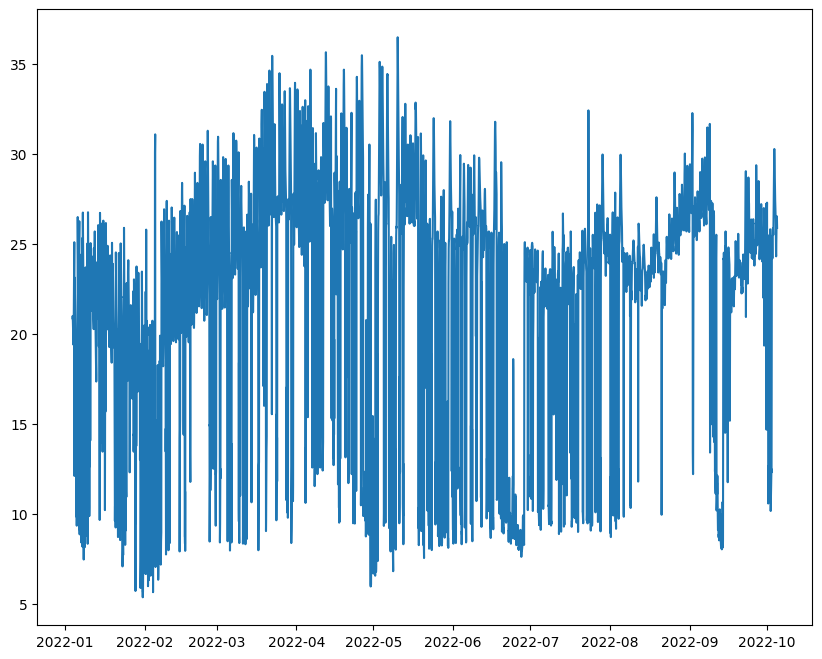

In [53]:
# plot the time series plot
plt.figure(figsize=(10,8))
plt.plot(train_data)

Datetime
2022-05-07 00:00:00    10.867
2022-05-07 01:00:00     9.867
2022-05-07 02:00:00     9.200
2022-05-07 03:00:00     9.633
2022-05-07 04:00:00    12.533
                        ...  
2022-05-20 20:00:00    24.267
2022-05-20 21:00:00    24.700
2022-05-20 22:00:00    24.933
2022-05-20 23:00:00    24.900
2022-05-21 00:00:00    24.133
Name: temperature, Length: 337, dtype: float64
Index(['2022-05-07', '2022-05-08', '2022-05-09', '2022-05-10', '2022-05-11',
       '2022-05-12', '2022-05-13', '2022-05-14', '2022-05-15', '2022-05-16',
       '2022-05-17', '2022-05-18', '2022-05-19', '2022-05-20', '2022-05-21'],
      dtype='object')


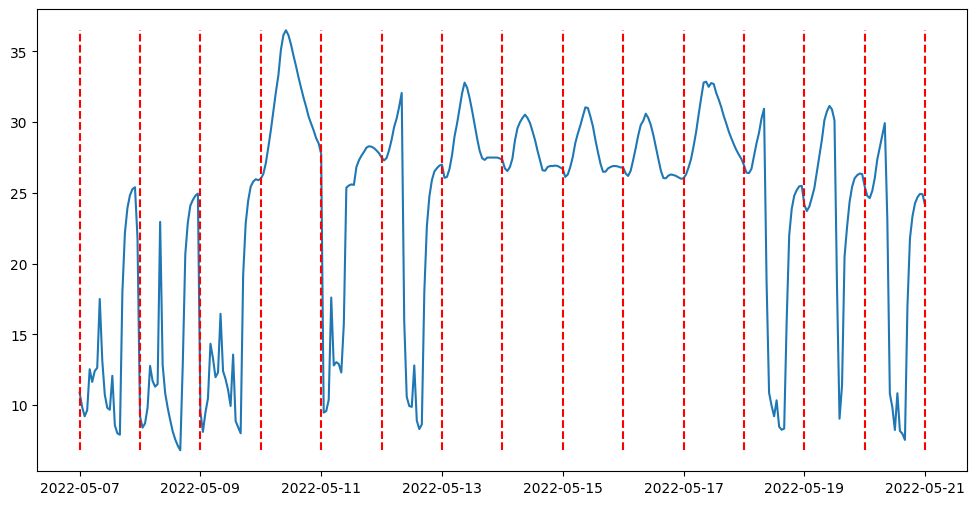

In [54]:
# plot a random N days
at_day = 123
duration_days = 14

plot_data = train_data.iloc[at_day*24:((at_day+duration_days)*24 + 1),0]
plt.figure(figsize=(12,6))
plt.plot(plot_data)

print(plot_data)
vertical_lines = pd.date_range(start=plot_data.index[0], end=plot_data.index[-1], inclusive='both', freq="d").map(lambda x: x.strftime('%Y-%m-%d'))
print(vertical_lines)
plt.vlines(vertical_lines, ymin=plot_data.min(), ymax=plot_data.max(),
            color='red', linestyles='--')


Since we can see that from this period, the temperature appears to have specific pattern every day (raise-and-drop). It appears that, maybe seasonal pattern = 24 may exist

By visualization, it is pretty hard to tell if the time series data are stationary or not. What we can determine is the variability does not appear to change over time because the max-min diffrence for different time interval appears to be constant. For the mean, the time series plot shows a bit fluctation, we cannot conclude the mean remains constant (just some random fluctation) or the mean shows up-and-down features over time.

Next take a look at the ACF plot

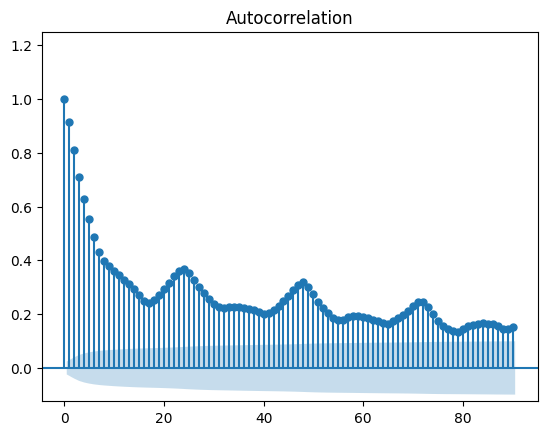

In [55]:
# ACF plot
plot_acf(train_data, auto_ylims=True, lags=90)
plt.show()

The ACF decay slowly (and not even decay to zero in the long run), so we can conclude that the time series is not stationary. (We may observe that the ACF plot has slighly higher at lag=24, 48, ..., but we have no clear evidence here. We will perform further method to assess the seasonality later)

We may also see this using KPSS test:
\begin{align}
H_0 &: \text{the process is stationary} \\
H_1 &: \text{the process is non stationary}
\end{align}

p.s. alternative is ADF test, we can refer to the official [statsmodels website for test of stationarity](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [56]:
from statsmodels.tsa.stattools import kpss

kpss(train_data)

(0.6180951551042116,
 0.02099134953598076,
 46,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The summary of KPSS test returned some info, in which the first is the test statistic; the second one is the p-value of the test.

Since the p-value is sufficiently small (\<0.05 and close to 0.01), we have sufficient evidence to reject $H_0$ and conclude that the underlying time series is non-stationary

# Further differencing, seasonality, and Auto-arima

Since we have conclude that the give time series data is nonstationary, we may try performing differencing to see if the differenced time series may show stationarity. We then see auto.arima may give us matching result

## First order differencing

In [57]:
from statsmodels.tsa.statespace.tools import diff

diff_data = diff(train_data)

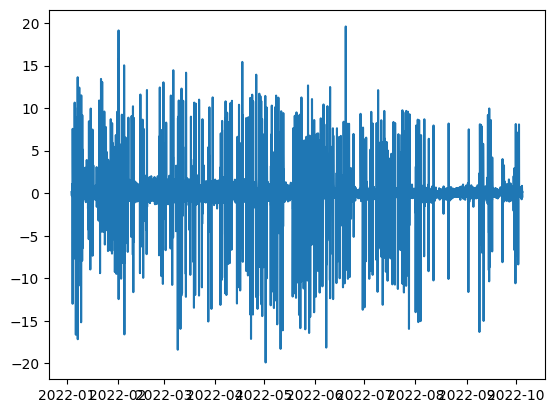

In [58]:
# time series plot of the differenced data
plt.plot(diff_data)

looks somehow better since we can see the mean of the data shows around 0 over time

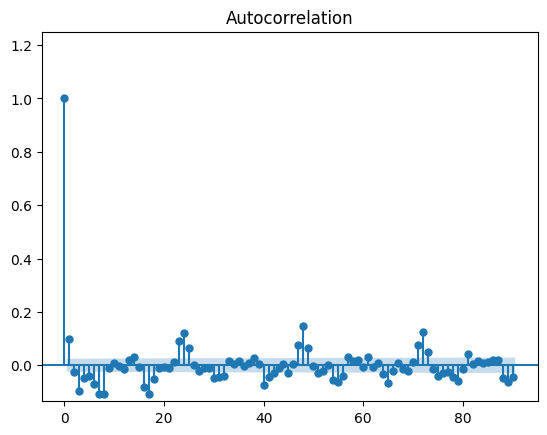

In [59]:
# ACF plot
plot_acf(diff_data, auto_ylims=True, lags=90)
plt.show()

shows quite good as well as it decay to zero (again, observed a spike at the multiple of lag=24)


In [60]:
# KPSS test
kpss(diff_data)

<ipython-input-60-dd1f5cbb2be3>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(diff_data)


(0.008602195483917649,
 0.1,
 89,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

the p-value of the KPSS test is 0.1 > 0.05, we failed to reject $H_0$ at 0.05 significance level.

According to the above findings, we can conclude that the differenced data is **stationary**

## Seasonality and seasonal order differencing

As we have seen that there appears to have seasonal (daily) pattern, it is also reasonable as the hour component should have high correlation between consecutive days (in reality, yearly pattern should also exist, but this dataset does not contain multiple years)

We will perform method to see if there have seasonal pattern

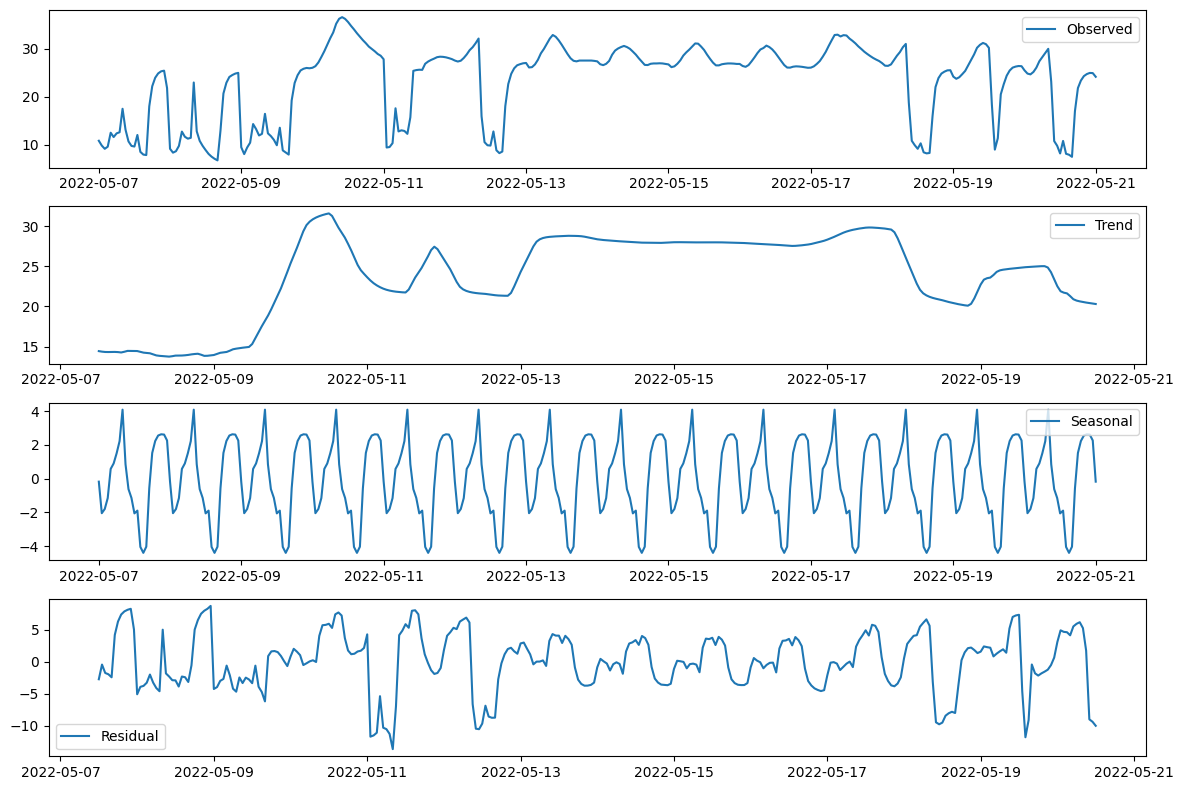

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose

# perform seasonal decomposition under period=24, using additive model
decompo = seasonal_decompose(plot_data, model='additive')

# plot all relevants results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decompo.observed, label='Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decompo.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decompo.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decompo.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

There is some resource that having indicator what if the data shows seasonality, see (Measuring Strength of trend and seasonality)[https://otexts.com/fpp2/seasonal-strength.html]

In [62]:
Fs = max(0, 1 - np.var(decompo.resid) / np.var(decompo.seasonal + decompo.resid))

Fs

0.20683984661049515

Since the indicator around 0.2 > 0, although not very large, it may shows weak stationality

In [63]:
# check also if the seasonal diff data is also stationary
kpss(diff(data, k_diff=1, k_seasonal_diff=1, seasonal_periods=24))

<ipython-input-63-63e354c4c782>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(diff(data, k_diff=1, k_seasonal_diff=1, seasonal_periods=24))


(0.004275872565710428,
 0.1,
 56,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value of the test is 0.1 > 0.05, so we fail to reject $H_0$, and conclude the seasonal diff with first order diff data is stationary

## Auto Arima

For R, there is a popular time series package **forecast**, in which provides a handy function called auto.arima for ARIMA order selection automatically. Although we should note that auto.arima provides us some insight for lowest AIC/BIC model, we should use it carefully to avoid choosing high complexity of model.

Similar package for Python is called **pmdarima**, see (pmdarima.arima.auto_arima)[https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html]


In [64]:
# supply the data, and then auto_arima method will return the "best" order of the data

#!pip install pmdarima
#from pmdarima.arima import auto_arima
#auto_arima(train_data)

# this will suggest ARIMA(1,1,3)(0,0,0)[0]

In [65]:
# because auto_arima is very slow, we will write the function by ourselves

Although auto_arima suggests an ARIMA(1,1,3) model. In common practice, we will choose the AR and MA order at most 2 if possible. So we will then try to look if lower order may give plausible result.

Also, to satisfy our claim with seasonal order=24, we will perform further investigation

To identify the order of autoregressive and moving average components, we have the following approach:

for pure MA(q) process, the ACF will have a clear cut-off after lag q
for pure AR(p) process, the PACF will have a clear cut-off after lag p

for ARMA process, we will see that both ACF and PACF should decay to 0 gradually, but not clear cut-off to be appeared

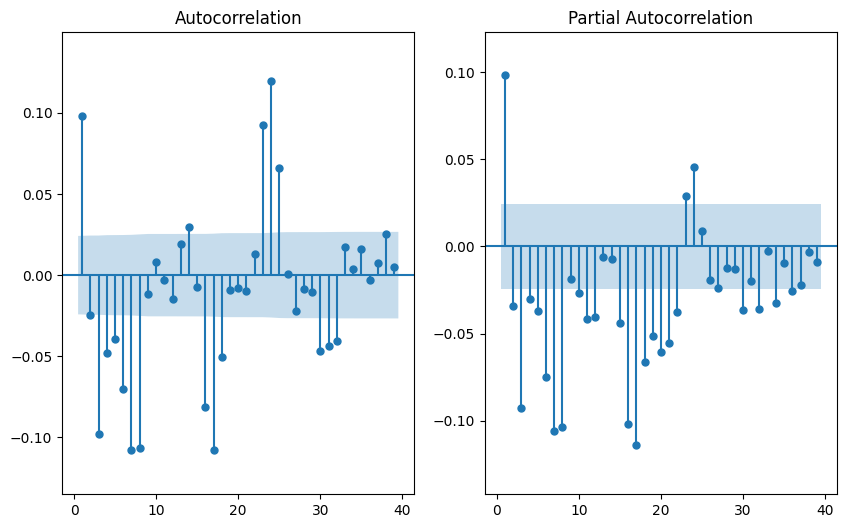

In [66]:
## ACF and PACF plot of the differenced data
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,6))
plot_acf(diff_data, ax=ax0, auto_ylims=True, zero=False) # for ACF, we can include or exclude lag-zero. The ACF of lag-zero is always 1
plot_pacf(diff_data, ax=ax1, auto_ylims=True, zero=False) # for PACF, we should exclude lag-zero

plt.show()

Since the process is stationary after first order differencing, so we can see that the ACF decay to zero as lag increases.

From these 2 plots, we see that the PACF doesn't decay to zero, and the ACF looks like close zero after lag 1, but it doesn't look having a clear cut-off.

So, the data appears to have both AR and MA components (also matching the auto-arima result)

# Fitting different models

Recall that the auto-arima suggests ARMA(1,3), however, we should try different models to see if introducing higher order can significantly reduce the AIC/BIC

We first starts with the lowest order fitting to differenced data

p.s. note that the coefficients of ar components needed to negate according to the official document (ARMA process)[https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html]
also, both ar and ma component needed to add zero-lag coefficient

## Using ARIMA

In [67]:
# define some handy method to simplify our works
from statsmodels.tsa.arima_process import arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

# training_data; nonseasonal orders, seasonal orders, test_data
def searching_arima(data, p, q, test_data, show_result=False):
  model = ARIMA(data, order=(p, 1, q), enforce_stationarity=True, enforce_invertibility=True)
  result = model.fit()

  ar_coef = np.r_[1, -1*result.arparams]
  ma_coef = np.r_[1, result.maparams]

  # instantiate a ARMA process using these coefficients, which can then be used to check the stationarity and invertibility of the model
  armaModel = ArmaProcess(ar_coef, ma_coef)

  # recall that the ARMA process is stationarity if the roots of AR characteristic polynomial all lie outside the unit circle
  # is invertible if the roots of MA characteristic polynomial all lie outside the unit circle

  if not (armaModel.isstationary and armaModel.isinvertible):
    print('is stationary? %s' % armaModel.isstationary)
    print('is invertible? %s' % armaModel.isinvertible)
    print('ar roots: ', result.arroots)
    print('ma roots: ', result.maroots)
    raise Exception("the given process is not stationary or invertible: stationarity: %s, invertibility: %s" % (result.isstationary, result.isinvertible))
  else:
  #  print('ar')
  #  print(ar_coef)
  #  print('ma')
  #  print(ma_coef)
    if show_result:
      print(result.summary())

      fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8,4))

      plot_acf(diff(data), ax=ax0, auto_ylims=True, zero=True, lags=30, label='sample ACF',) # for ACF, we can include or exclude lag-zero. The ACF of lag-zero is always 1
      ax0.plot(range(0, 30), arma_acf(ar_coef, ma_coef, lags=30), color='red', label='theoretical ACF')
      ax0.legend()

      plot_pacf(diff(data), ax=ax1, auto_ylims=True, zero=True, lags=30, label='sample PACF') # for PACF, we can exclude lag-zero if necessary
      ax1.plot(range(0, 30), arma_pacf(ar_coef, ma_coef, lags=30), color='red', label='theoretical PACF')
      ax1.legend()

      fig.suptitle('ARIMA(%s,1,%s)' % (p, q))
      plt.show()


    # prediction
    steps = test_data.shape[0]
    prediction = result.forecast(steps=steps)

    mse = mean_squared_error(prediction, test_data)

    return {'p': p, 'q': q, 'AIC': result.aic, 'AICc': result.aicc, 'BIC': result.bic, 'test_mse': mse}



In [68]:
arima_search_list = []
for i in range(0,4):
  for j in range(0,4):
    try:
      df = searching_arima(train_data, i, j, test_data)
      arima_search_list.append(df)
    except:
      print('the process is not feasible: (p,q)=(%s,%s)' % (i,j))


arima_search_df = pd.DataFrame(arima_search_list)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dat

In [69]:
arima_search_df

p  q           AIC          AICc           BIC  test_mse
0   0  0  32472.936165  32472.936774  32479.727195  1.233245
1   0  1  32408.346832  32408.348658  32421.928892  1.250936
2   0  2  32410.087543  32410.091195  32430.460633  1.248547
3   0  3  32349.499597  32349.505685  32376.663717  1.218117
4   1  0  32411.001285  32411.003111  32424.583345  1.253750
5   1  1  32410.260972  32410.264624  32430.634061  1.250174
6   1  2  32010.630171  32010.636259  32037.794291  5.093243
7   1  3  31976.316935  31976.326069  32010.272085  4.696400
8   2  0  32405.258177  32405.261829  32425.631266  1.242275
9   2  1  31990.074235  31990.080323  32017.238354  4.851915
10  2  2  31981.690774  31981.699908  32015.645923  4.490591
11  2  3  31976.885302  31976.898091  32017.631481  4.775962
12  3  0  32350.261100  32350.267188  32377.425220  1.222165
13  3  1  31980.015553  31980.024687  32013.970703  4.547110
14  3  2  31977.325909  31977.338699  32018.072088  4.645688
15  3  3  31978.745035  31978.762090  32026.282244  4.748637

In [70]:
# sort the DataFrame according to AIC
arima_search_df.sort_values(by=['AIC'])

p  q           AIC          AICc           BIC  test_mse
7   1  3  31976.316935  31976.326069  32010.272085  4.696400
11  2  3  31976.885302  31976.898091  32017.631481  4.775962
14  3  2  31977.325909  31977.338699  32018.072088  4.645688
15  3  3  31978.745035  31978.762090  32026.282244  4.748637
13  3  1  31980.015553  31980.024687  32013.970703  4.547110
10  2  2  31981.690774  31981.699908  32015.645923  4.490591
9   2  1  31990.074235  31990.080323  32017.238354  4.851915
6   1  2  32010.630171  32010.636259  32037.794291  5.093243
3   0  3  32349.499597  32349.505685  32376.663717  1.218117
12  3  0  32350.261100  32350.267188  32377.425220  1.222165
8   2  0  32405.258177  32405.261829  32425.631266  1.242275
1   0  1  32408.346832  32408.348658  32421.928892  1.250936
2   0  2  32410.087543  32410.091195  32430.460633  1.248547
5   1  1  32410.260972  32410.264624  32430.634061  1.250174
4   1  0  32411.001285  32411.003111  32424.583345  1.253750
0   0  0  32472.936165  32472.936774  32479.727195  1.233245

Since here we can also conclude that ARMA(1,3) has the lowest AIC (also AICc and BIC). All candidates with higher ar/ma orders can be ignored.

One maybe interested in is the models with total orders (p+q=4) slightly less order: i.e.
ARMA(1,2), ARMA(0,3), ARMA(2,1)

It is worth note that ARMA(0,3) has AIC 400 higher than ARMA(1,3), but its test_mse is just 25% that of ARMA(1,3), so we may also consider it.

Here, we do not consider ARMA(2,2) as if we accept total order=4, we should rather consider ARMA(1,3) as it has the lowest AIC/BIC

In [81]:
# sort the DataFrame according to AIC
arima_search_df2 = arima_search_df.loc[[7,9,6,3]].sort_values(['AIC'])
arima_search_df2

p  q           AIC          AICc           BIC  test_mse
7  1  3  31976.316935  31976.326069  32010.272085  4.696400
9  2  1  31990.074235  31990.080323  32017.238354  4.851915
6  1  2  32010.630171  32010.636259  32037.794291  5.093243
3  0  3  32349.499597  32349.505685  32376.663717  1.218117

All these 4 models seemed not differ a lot in AIC, AICc and BIC.

We revisit the model summary and plots again

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 6576
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -15983.158
Date:                Tue, 13 Feb 2024   AIC                          31976.317
Time:                        04:21:48   BIC                          32010.272
Sample:                    01-04-2022   HQIC                         31988.054
                         - 10-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8224      0.010     84.748      0.000       0.803       0.841
ma.L1         -0.7831      0.011    -74.500      0.000      -0.804      -0.763
ma.L2         -0.1126      0.010    -10.729      0.0

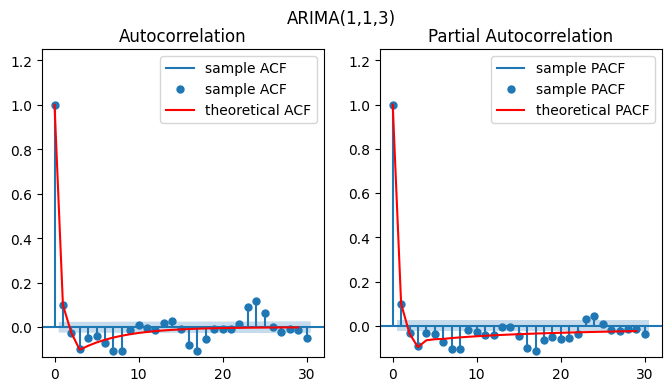

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 6576
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -15991.037
Date:                Tue, 13 Feb 2024   AIC                          31990.074
Time:                        04:21:51   BIC                          32017.238
Sample:                    01-04-2022   HQIC                         31999.464
                         - 10-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0314      0.009    120.892      0.000       1.015       1.048
ar.L2         -0.1640      0.007    -22.509      0.000      -0.178      -0.150
ma.L1         -0.9880      0.002   -469.828      0.0

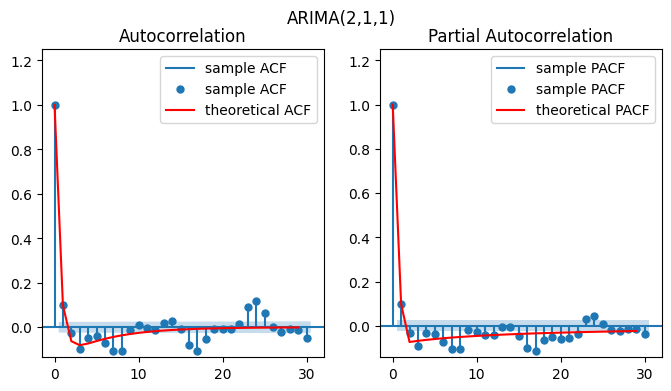

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 6576
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -16001.315
Date:                Tue, 13 Feb 2024   AIC                          32010.630
Time:                        04:21:54   BIC                          32037.794
Sample:                    01-04-2022   HQIC                         32020.020
                         - 10-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8560      0.008    109.246      0.000       0.841       0.871
ma.L1         -0.8287      0.009    -95.670      0.000      -0.846      -0.812
ma.L2         -0.1596      0.008    -19.980      0.0

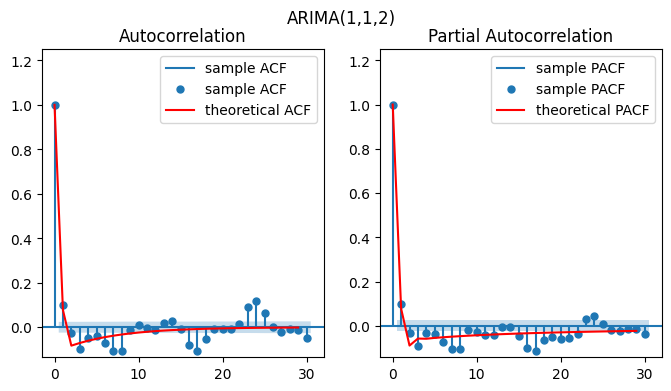

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 6576
Model:                 ARIMA(0, 1, 3)   Log Likelihood              -16170.750
Date:                Tue, 13 Feb 2024   AIC                          32349.500
Time:                        04:21:55   BIC                          32376.664
Sample:                    01-04-2022   HQIC                         32358.889
                         - 10-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0873      0.008     11.469      0.000       0.072       0.102
ma.L2         -0.0298      0.011     -2.789      0.005      -0.051      -0.009
ma.L3         -0.1062      0.011    -10.056      0.0

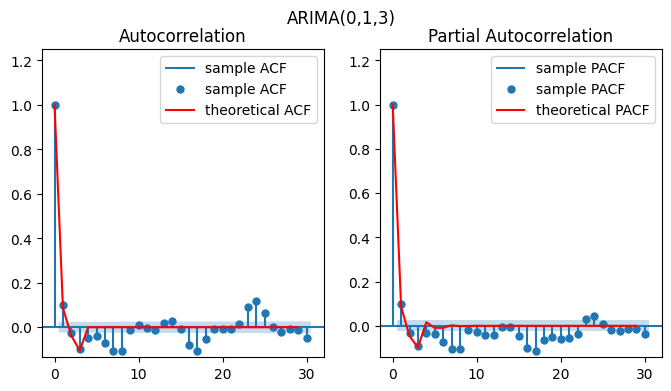

In [82]:
ar1_ma3 = searching_arima(train_data, 1, 3, test_data, show_result=True)
ar2_ma1 = searching_arima(train_data, 2, 1, test_data, show_result=True)
ar1_ma2 = searching_arima(train_data, 1, 2, test_data, show_result=True)
ar0_ma3 = searching_arima(train_data, 0, 3, test_data, show_result=True)

All 3 models having a quite good fit of ACF and PACF plots. And from the statistical test, for each model, the parameter estimate of each AR/MA coefficients are significant.

Here we may conclude that all these 3 models can be our candidates. We then assess the test MSE and diagnostic analysis as well, to see which one if our best model

In [73]:

def forecast_plot1(p_q_pairs_df, train_data, test_data):

  plt.figure(figsize=(12,6))
  plt.plot(train_data[-100:], color='black', label="train_data")
  plt.plot(test_data, color='blue', label="test_data")
  colors = ['red','green','brown', 'purple']
  for i in range(p_q_pairs_df.shape[0]):
    row = p_q_pairs_df.loc[i]
    p = p_q_pairs_df.iloc[i, 0]
    q = p_q_pairs_df.iloc[i, 1]

    model = ARIMA(train_data, order=(p, 1, q))
    result = model.fit()
    prediction = result.get_forecast(steps=test_data.shape[0])
    prediction = pd.concat((prediction.predicted_mean, prediction.conf_int(alpha=0.05)), axis=1)

    color = colors[i]
    plt.plot(prediction['predicted_mean'], color=color, label='ARMA(%s,%s) forecast' % (p,q))
    plt.plot(prediction['lower temperature'], color=color, linestyle='--', label='ARMA(%s,%s) 95 Bound' % (p,q))
    plt.plot(prediction['upper temperature'], color=color, linestyle='--')
    plt.ylim([0,40])

  plt.legend()
  plt.show()




In [95]:
p_q_pairs_df = pd.DataFrame(columns=['p', 'q'])
p_q_pairs_df.loc[0] = [2, 1]
p_q_pairs_df.loc[1] = [1, 3]
p_q_pairs_df.loc[2] = [1, 2]
p_q_pairs_df.loc[3] = [0, 3]


p_q_pairs_df


p  q
0  2  1
1  1  3
2  1  2
3  0  3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

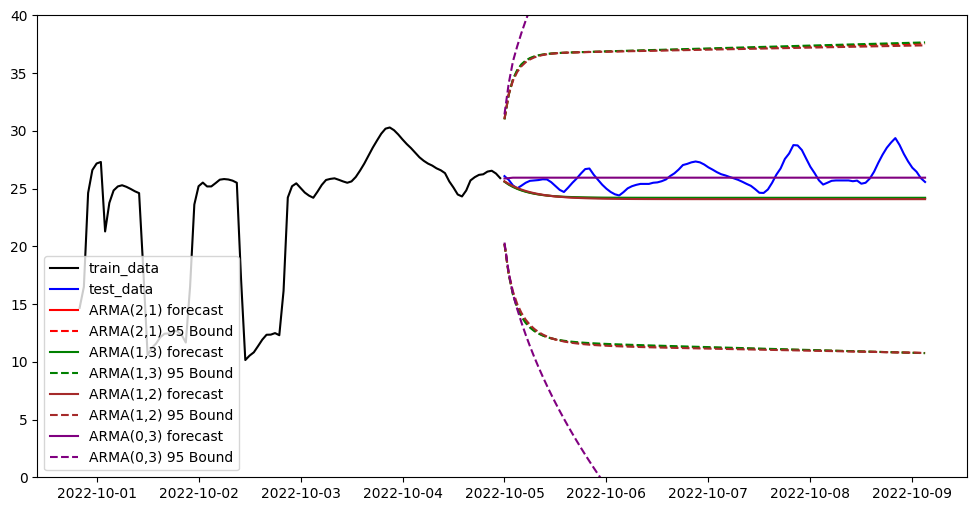

In [96]:
forecast_plot1(p_q_pairs_df, train_data, test_data)

Although low test_mse, clearly these 4 models are not applicable as the test data and the forecasted data are not close.


Next look at with seasonality

## Using SARIMA

fitting SARIMA, but fixed first order differencing = 1; seasonal order differencing = 1; seasonal period = 24

In [76]:
# define some handy method to simplify our works
from statsmodels.tsa.statespace.sarimax import SARIMAX


# training_data; nonseasonal orders, seasonal orders, test_data
def searching_sarima(data, p, q, P, Q, test_data, show_result=True):
  model = SARIMAX(data, order=(p, 1, q), seasonal_order=(P, 1, Q, 24), enforce_stationarity=True, enforce_invertibility=True)
  result = model.fit()

  # instantiate a ARMA process using these coefficients, which can then be used to check the stationarity and invertibility of the model
#  armaModel = ArmaProcess(ar_coef, ma_coef, )

  # recall that the ARMA process is stationarity if the roots of AR characteristic polynomial all lie outside the unit circle
  # is invertible if the roots of MA characteristic polynomial all lie outside the unit circle

#  if not (armaModel.isstationary and armaModel.isinvertible):
#    print('is stationary? %s' % armaModel.isstationary)
#    print('is invertible? %s' % armaModel.isinvertible)
#    print('ar roots: ', result.arroots)
#    print('ma roots: ', result.maroots)
#    raise Exception("the given process is not stationary or invertible: stationarity: %s, invertibility: %s" % (result.isstationary, result.isinvertible))
#  else:
  #  print('ar')
  #  print(ar_coef)
  #  print('ma')
  #  print(ma_coef)
  if show_result:
    print(result.summary())

    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8,4))
    plot_acf(diff(data, k_diff=1, k_seasonal_diff=1, seasonal_periods=24), ax=ax0, auto_ylims=True, zero=True, lags=30, label='sample ACF',) # for ACF, we can include or exclude lag-zero. The ACF of lag-zero is always 1
    ax0.plot(range(0, 30), arma_acf(result.polynomial_reduced_ar, result.polynomial_reduced_ma, lags=30), color='red', label='theoretical ACF')
    ax0.legend()

    plot_pacf(diff(data, k_diff=1, k_seasonal_diff=1, seasonal_periods=24), ax=ax1, auto_ylims=True, zero=True, lags=30, label='sample PACF') # for PACF, we can exclude lag-zero if necessary
    ax1.plot(range(0, 30), arma_pacf(result.polynomial_reduced_ar, result.polynomial_reduced_ma, lags=30), color='red', label='theoretical PACF')
    ax1.legend()

    fig.suptitle('SARIMA(%s,1,%s)(%s,1,%s)[24]' % (p,q,P,Q))
    plt.show()


  # prediction
  steps = test_data.shape[0]
  prediction = result.forecast(steps=steps)

  mse = mean_squared_error(prediction, test_data)

  return {'p': p, 'q': q, 'P': P, 'Q': Q, 'AIC': result.aic, 'AICc': result.aicc, 'BIC': result.bic, 'test_mse': mse}


running (p,q,P,Q)=(0,0,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 24)   Log Likelihood              -18032.236
Date:                            Tue, 13 Feb 2024   AIC                          36066.472
Time:                                    03:11:21   BIC                          36073.259
Sample:                                01-04-2022   HQIC                         36068.819
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        14.4011      0.117    123.154      0.000      14.172      14.630
Ljung-Box (L1) (Q):                

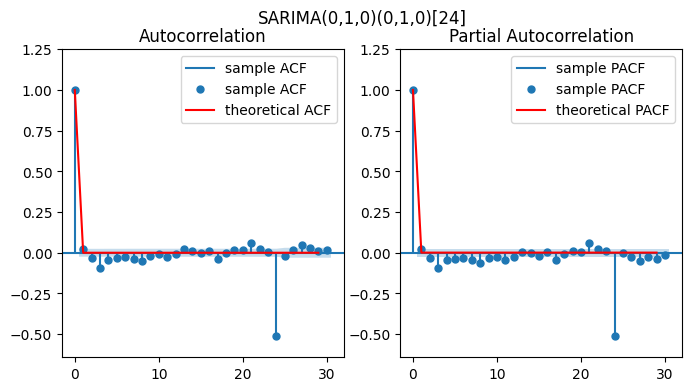

***************************
running (p,q,P,Q)=(0,0,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 24)   Log Likelihood              -16062.333
Date:                              Tue, 13 Feb 2024   AIC                          32128.666
Time:                                      03:11:33   BIC                          32142.240
Sample:                                  01-04-2022   HQIC                         32133.359
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L24      -0.9206      0.004   -222.698      0.000      -0.929      -0.912
sigma2         7.83

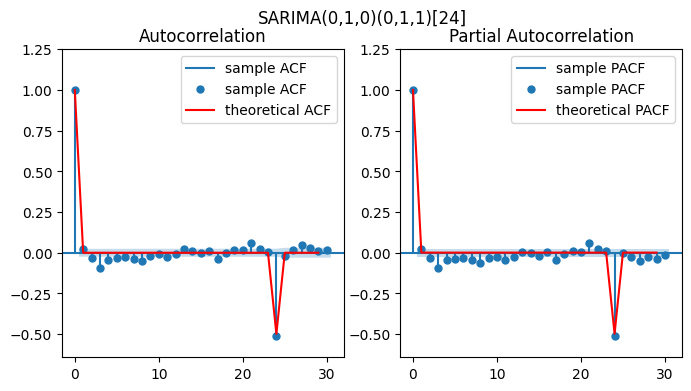

***************************
running (p,q,P,Q)=(0,0,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -17026.889
Date:                            Tue, 13 Feb 2024   AIC                          34057.778
Time:                                    03:11:38   BIC                          34071.353
Sample:                                01-04-2022   HQIC                         34062.472
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24      -0.5142      0.006    -90.481      0.000      -0.525      -0.503
sigma2        10.5830      0.087   

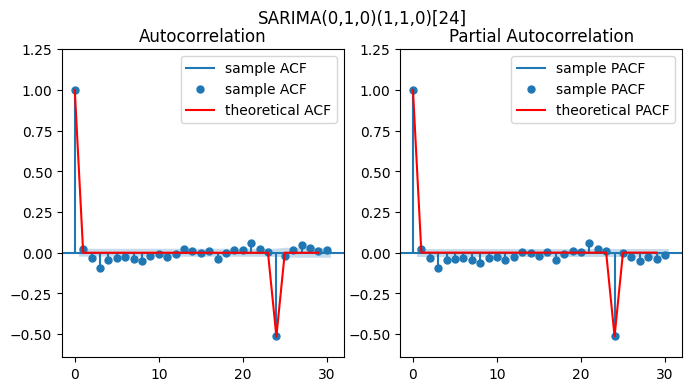

***************************
running (p,q,P,Q)=(0,0,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 24)   Log Likelihood              -16062.164
Date:                              Tue, 13 Feb 2024   AIC                          32130.328
Time:                                      03:11:56   BIC                          32150.691
Sample:                                  01-04-2022   HQIC                         32137.368
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.0081      0.009      0.860      0.390      -0.010       0.027
ma.S.L24      -0.92

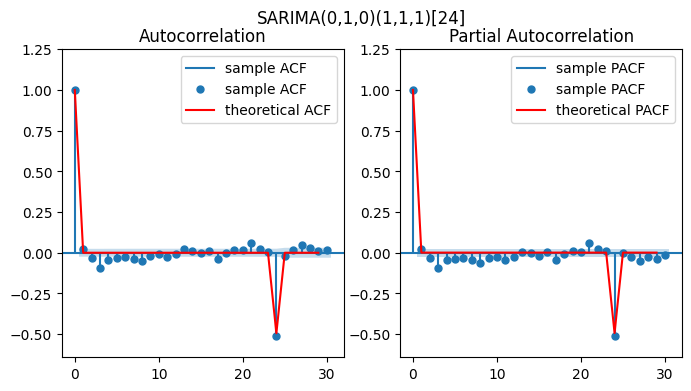

***************************
running (p,q,P,Q)=(0,1,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 24)   Log Likelihood              -18030.483
Date:                             Tue, 13 Feb 2024   AIC                          36064.965
Time:                                     03:11:59   BIC                          36078.540
Sample:                                 01-04-2022   HQIC                         36069.659
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0239      0.008      3.097      0.002       0.009       0.039
sigma2        14.3934      

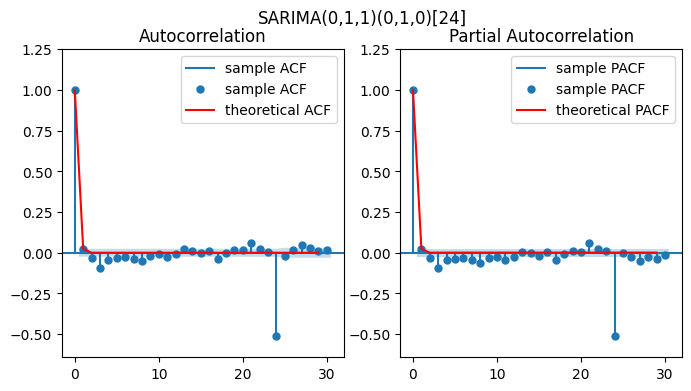

***************************
running (p,q,P,Q)=(0,1,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -16048.509
Date:                            Tue, 13 Feb 2024   AIC                          32103.018
Time:                                    03:12:15   BIC                          32123.380
Sample:                                01-04-2022   HQIC                         32110.058
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0670      0.008      8.931      0.000       0.052       0.082
ma.S.L24      -0.9239      0.004   

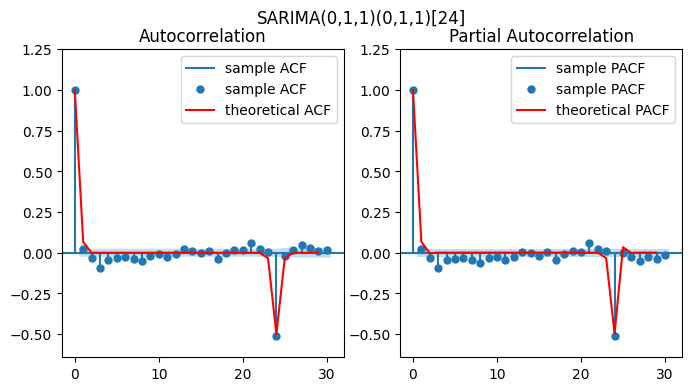

***************************
running (p,q,P,Q)=(0,1,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 24)   Log Likelihood              -17023.642
Date:                             Tue, 13 Feb 2024   AIC                          34053.283
Time:                                     03:12:23   BIC                          34073.645
Sample:                                 01-04-2022   HQIC                         34060.323
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0324      0.008      4.022      0.000       0.017       0.048
ar.S.L24      -0.5147      

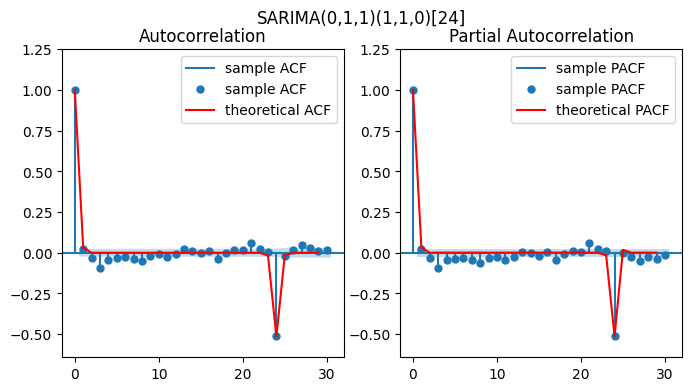

***************************
running (p,q,P,Q)=(0,1,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -16048.445
Date:                            Tue, 13 Feb 2024   AIC                          32104.889
Time:                                    03:12:47   BIC                          32132.039
Sample:                                01-04-2022   HQIC                         32114.276
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0668      0.008      8.907      0.000       0.052       0.082
ar.S.L24       0.0050      0.009   

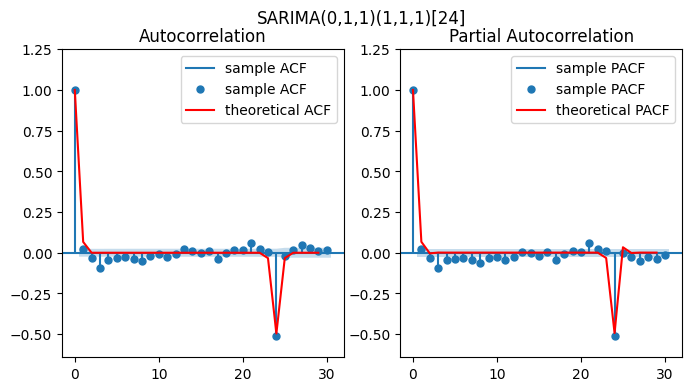

***************************
running (p,q,P,Q)=(0,2,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 24)   Log Likelihood              -18026.946
Date:                             Tue, 13 Feb 2024   AIC                          36059.891
Time:                                     03:12:50   BIC                          36080.253
Sample:                                 01-04-2022   HQIC                         36066.931
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0164      0.008      2.088      0.037       0.001       0.032
ma.L2         -0.0352      

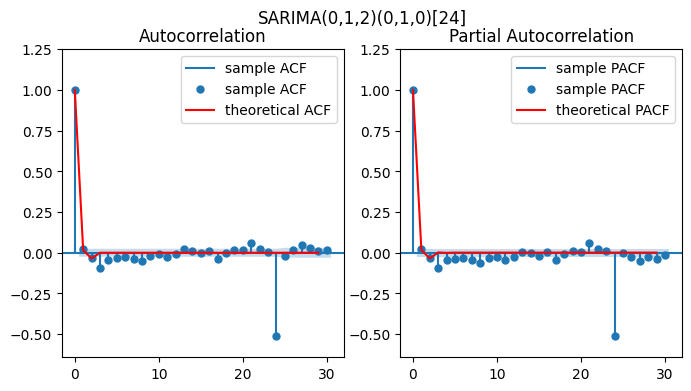

***************************
running (p,q,P,Q)=(0,2,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -16046.336
Date:                              Tue, 13 Feb 2024   AIC                          32100.671
Time:                                      03:13:10   BIC                          32127.821
Sample:                                  01-04-2022   HQIC                         32110.058
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0601      0.008      7.707      0.000       0.045       0.075
ma.L2         -0.02

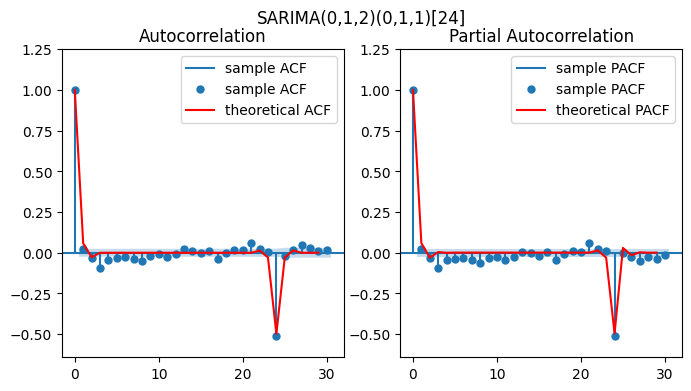

***************************
running (p,q,P,Q)=(0,2,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 24)   Log Likelihood              -17021.015
Date:                             Tue, 13 Feb 2024   AIC                          34050.031
Time:                                     03:13:19   BIC                          34077.180
Sample:                                 01-04-2022   HQIC                         34059.417
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0264      0.008      3.212      0.001       0.010       0.043
ma.L2         -0.0303      

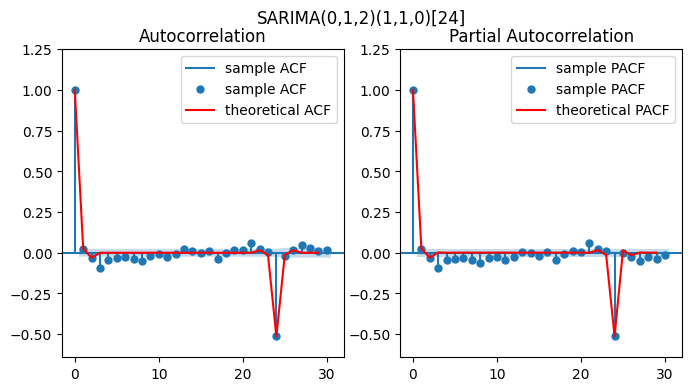

***************************
running (p,q,P,Q)=(0,2,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 24)   Log Likelihood              -16046.254
Date:                              Tue, 13 Feb 2024   AIC                          32102.509
Time:                                      03:13:45   BIC                          32136.445
Sample:                                  01-04-2022   HQIC                         32114.242
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0599      0.008      7.679      0.000       0.045       0.075
ma.L2         -0.02

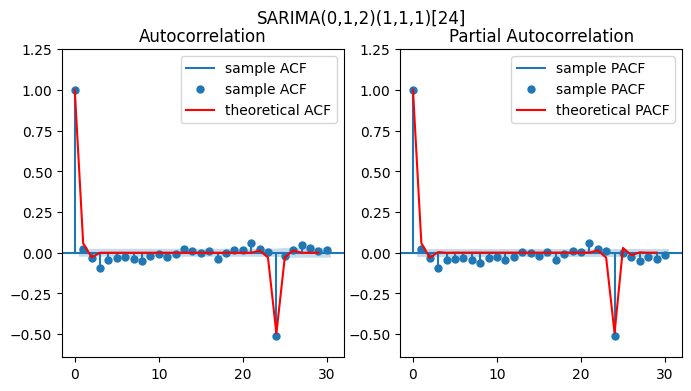

***************************
running (p,q,P,Q)=(0,3,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 3)x(0, 1, [], 24)   Log Likelihood              -17994.710
Date:                             Tue, 13 Feb 2024   AIC                          35997.421
Time:                                     03:13:50   BIC                          36024.570
Sample:                                 01-04-2022   HQIC                         36006.807
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0080      0.008      1.006      0.314      -0.008       0.024
ma.L2         -0.0486      

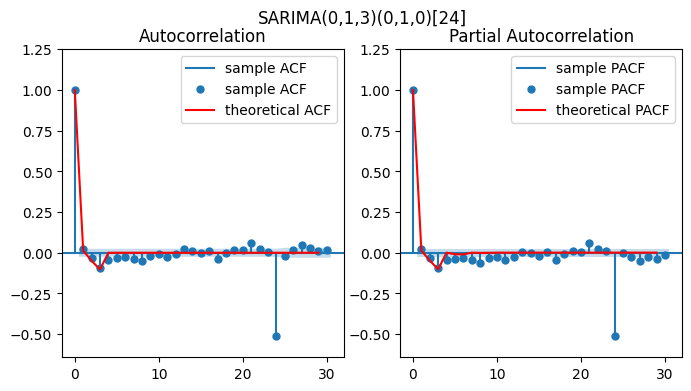

***************************
running (p,q,P,Q)=(0,3,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 24)   Log Likelihood              -16012.017
Date:                              Tue, 13 Feb 2024   AIC                          32034.035
Time:                                      03:14:20   BIC                          32067.972
Sample:                                  01-04-2022   HQIC                         32045.768
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0502      0.008      6.305      0.000       0.035       0.066
ma.L2         -0.04

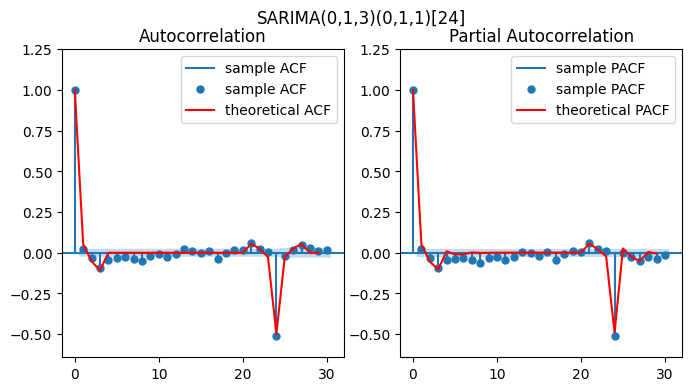

***************************
running (p,q,P,Q)=(0,3,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 3)x(1, 1, [], 24)   Log Likelihood              -16995.326
Date:                             Tue, 13 Feb 2024   AIC                          34000.652
Time:                                     03:14:32   BIC                          34034.588
Sample:                                 01-04-2022   HQIC                         34012.385
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0180      0.008      2.167      0.030       0.002       0.034
ma.L2         -0.0446      

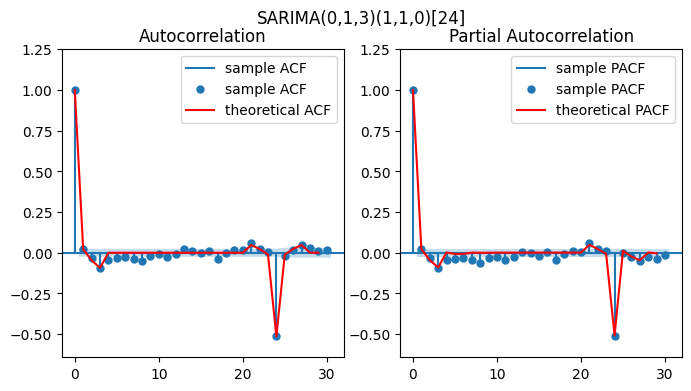

***************************
running (p,q,P,Q)=(0,3,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(0, 1, 3)x(1, 1, [1], 24)   Log Likelihood              -16011.908
Date:                              Tue, 13 Feb 2024   AIC                          32035.816
Time:                                      03:15:09   BIC                          32076.540
Sample:                                  01-04-2022   HQIC                         32049.896
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0500      0.008      6.275      0.000       0.034       0.066
ma.L2         -0.04

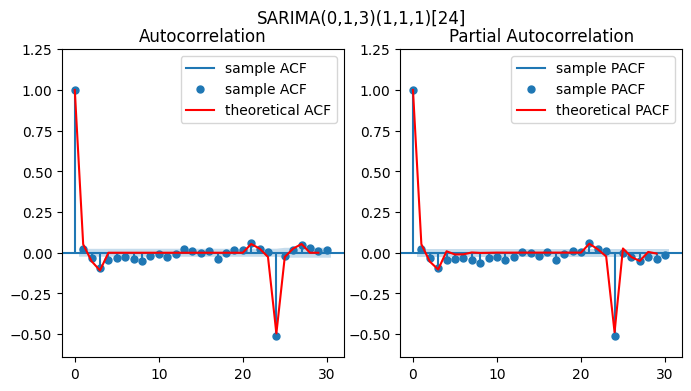

***************************
running (p,q,P,Q)=(1,0,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 24)   Log Likelihood              -18030.599
Date:                            Tue, 13 Feb 2024   AIC                          36065.198
Time:                                    03:15:11   BIC                          36078.772
Sample:                                01-04-2022   HQIC                         36069.891
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0224      0.008      2.885      0.004       0.007       0.038
sigma2        14.3938      0.118   

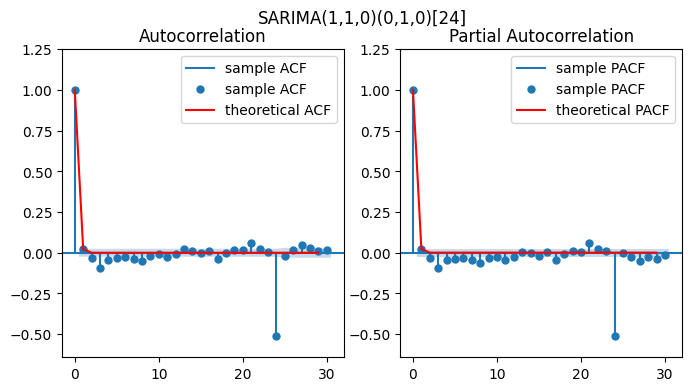

***************************
running (p,q,P,Q)=(1,0,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 24)   Log Likelihood              -16049.413
Date:                              Tue, 13 Feb 2024   AIC                          32104.826
Time:                                      03:15:26   BIC                          32125.188
Sample:                                  01-04-2022   HQIC                         32111.866
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0631      0.008      8.224      0.000       0.048       0.078
ma.S.L24      -0.92

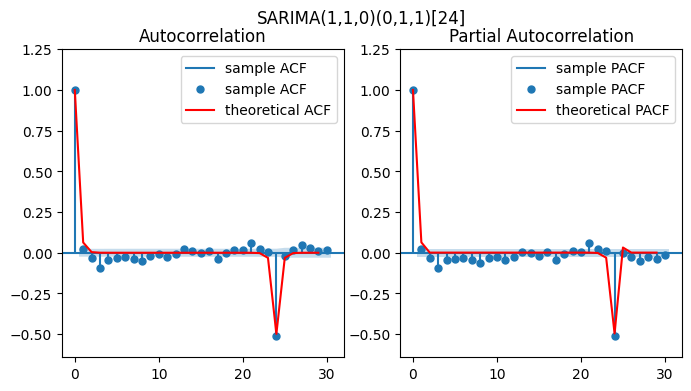

***************************
running (p,q,P,Q)=(1,0,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -17023.834
Date:                            Tue, 13 Feb 2024   AIC                          34053.668
Time:                                    03:15:34   BIC                          34074.030
Sample:                                01-04-2022   HQIC                         34060.708
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0305      0.008      3.765      0.000       0.015       0.046
ar.S.L24      -0.5146      0.006   

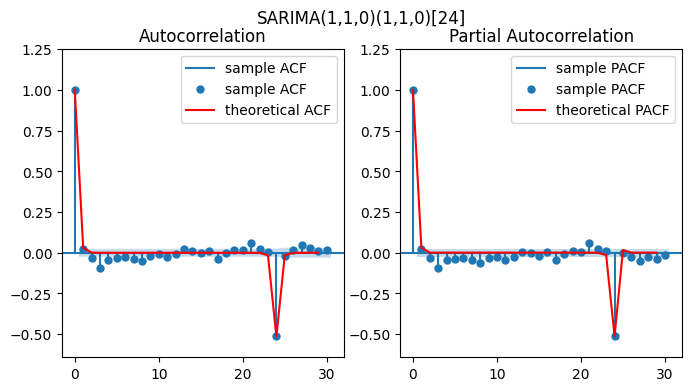

***************************
running (p,q,P,Q)=(1,0,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 24)   Log Likelihood              -16049.345
Date:                              Tue, 13 Feb 2024   AIC                          32106.690
Time:                                      03:15:54   BIC                          32133.840
Sample:                                  01-04-2022   HQIC                         32116.077
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0629      0.008      8.201      0.000       0.048       0.078
ar.S.L24       0.00

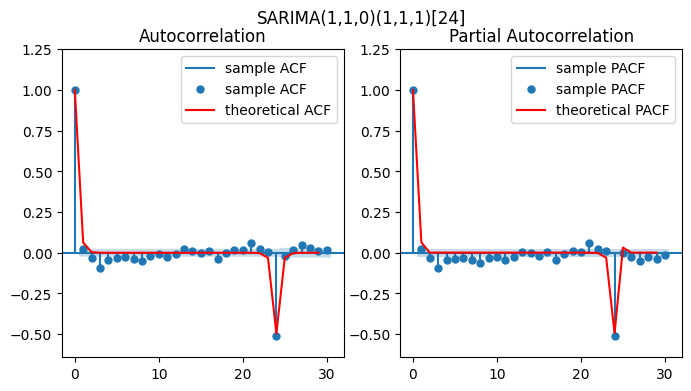

***************************
running (p,q,P,Q)=(1,1,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 24)   Log Likelihood              -18030.093
Date:                             Tue, 13 Feb 2024   AIC                          36066.186
Time:                                     03:16:05   BIC                          36086.549
Sample:                                 01-04-2022   HQIC                         36073.226
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1603      0.385     -0.417      0.677      -0.914       0.594
ma.L1          0.1855      

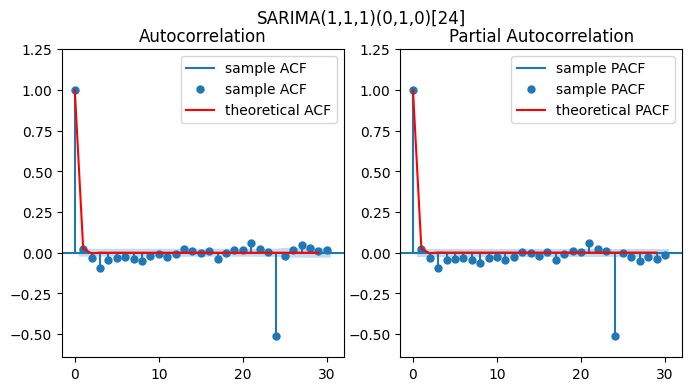

***************************
running (p,q,P,Q)=(1,1,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -16047.981
Date:                            Tue, 13 Feb 2024   AIC                          32103.962
Time:                                    03:16:33   BIC                          32131.111
Sample:                                01-04-2022   HQIC                         32113.348
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1011      0.149     -0.678      0.497      -0.393       0.191
ma.L1          0.1674      0.147   

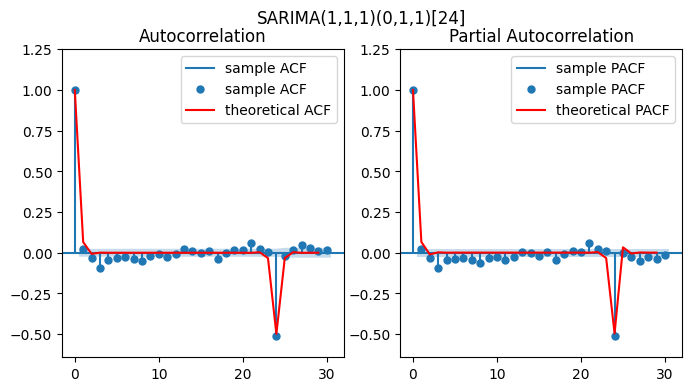

***************************
running (p,q,P,Q)=(1,1,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 24)   Log Likelihood              -17023.226
Date:                             Tue, 13 Feb 2024   AIC                          34054.452
Time:                                     03:16:56   BIC                          34081.602
Sample:                                 01-04-2022   HQIC                         34063.839
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1472      0.299     -0.492      0.623      -0.734       0.439
ma.L1          0.1803      

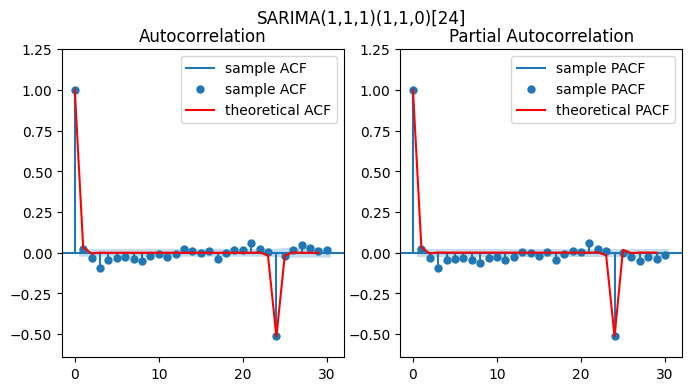

***************************
running (p,q,P,Q)=(1,1,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -16047.914
Date:                            Tue, 13 Feb 2024   AIC                          32105.828
Time:                                    03:17:38   BIC                          32139.764
Sample:                                01-04-2022   HQIC                         32117.561
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1010      0.150     -0.676      0.499      -0.394       0.192
ma.L1          0.1671      0.147   

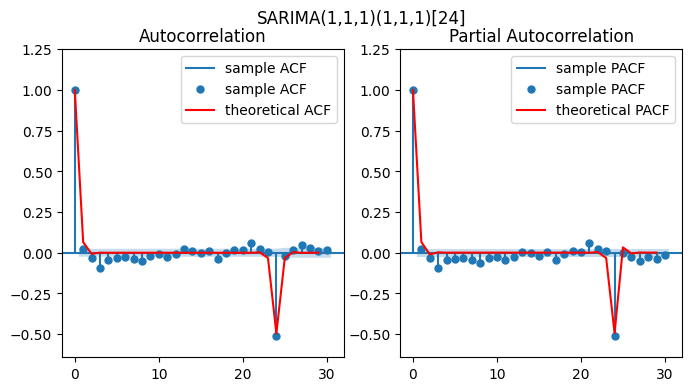

***************************
running (p,q,P,Q)=(1,2,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 24)   Log Likelihood              -17809.324
Date:                             Tue, 13 Feb 2024   AIC                          35626.648
Time:                                     03:18:11   BIC                          35653.798
Sample:                                 01-04-2022   HQIC                         35636.035
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8597      0.007    131.225      0.000       0.847       0.873
ma.L1         -0.9091      

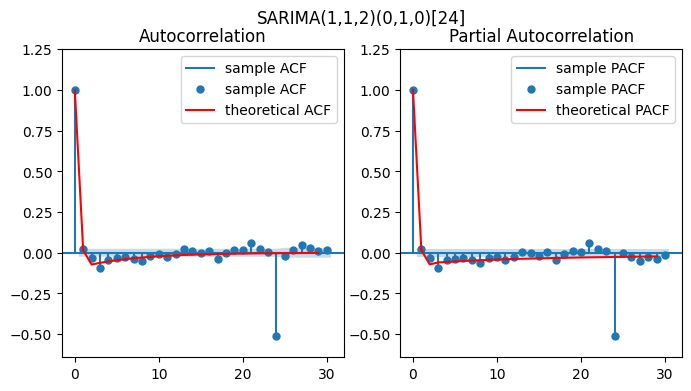

***************************
running (p,q,P,Q)=(1,2,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -15863.120
Date:                              Tue, 13 Feb 2024   AIC                          31736.239
Time:                                      03:18:54   BIC                          31770.176
Sample:                                  01-04-2022   HQIC                         31747.972
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8678      0.007    117.096      0.000       0.853       0.882
ma.L1         -0.86

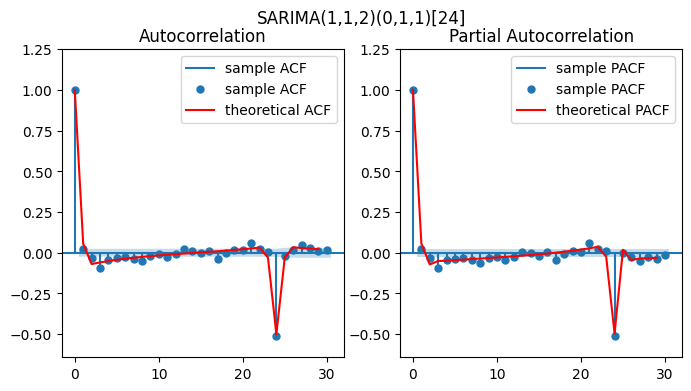

***************************
running (p,q,P,Q)=(1,2,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 2)x(1, 1, [], 24)   Log Likelihood              -16816.436
Date:                             Tue, 13 Feb 2024   AIC                          33642.872
Time:                                     03:20:24   BIC                          33676.809
Sample:                                 01-04-2022   HQIC                         33654.605
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8685      0.006    145.588      0.000       0.857       0.880
ma.L1         -0.9055      

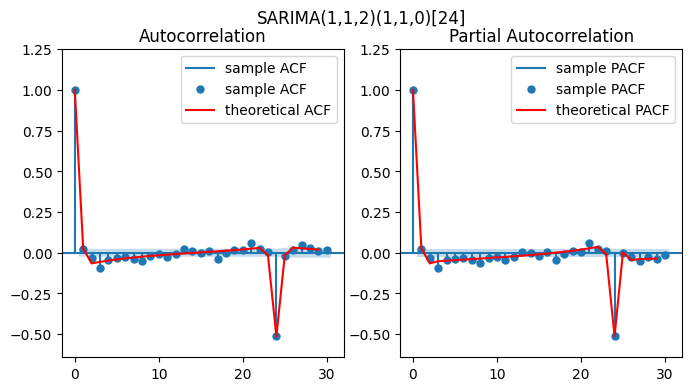

***************************
running (p,q,P,Q)=(1,2,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 24)   Log Likelihood              -15862.640
Date:                              Tue, 13 Feb 2024   AIC                          31737.280
Time:                                      03:21:30   BIC                          31778.004
Sample:                                  01-04-2022   HQIC                         31751.360
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8682      0.007    117.771      0.000       0.854       0.883
ma.L1         -0.86

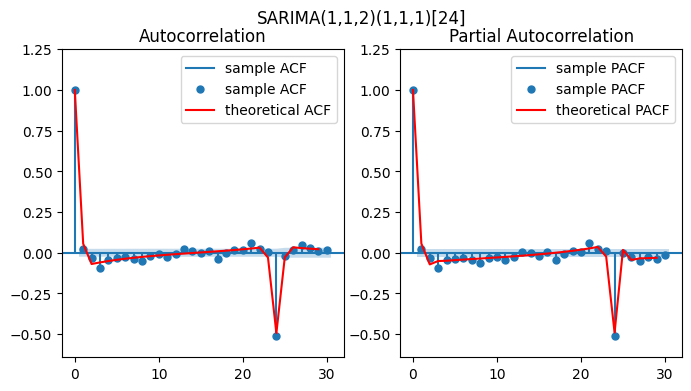

***************************
running (p,q,P,Q)=(1,3,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 3)x(0, 1, [], 24)   Log Likelihood              -17802.358
Date:                             Tue, 13 Feb 2024   AIC                          35614.716
Time:                                     03:22:12   BIC                          35648.653
Sample:                                 01-04-2022   HQIC                         35626.449
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8432      0.008    106.696      0.000       0.828       0.859
ma.L1         -0.8869      

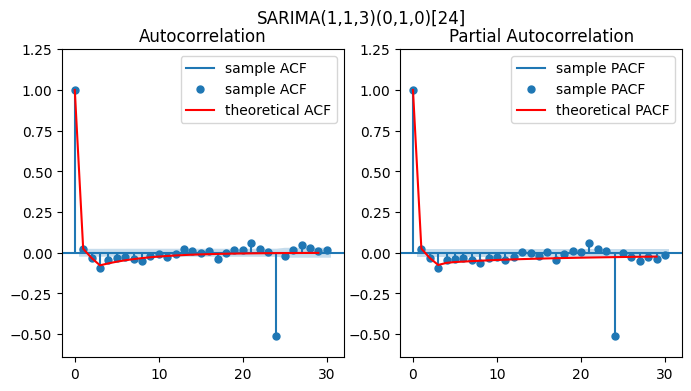

***************************
running (p,q,P,Q)=(1,3,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 24)   Log Likelihood              -15854.801
Date:                              Tue, 13 Feb 2024   AIC                          31721.602
Time:                                      03:23:22   BIC                          31762.326
Sample:                                  01-04-2022   HQIC                         31735.682
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8435      0.009     91.585      0.000       0.825       0.862
ma.L1         -0.83

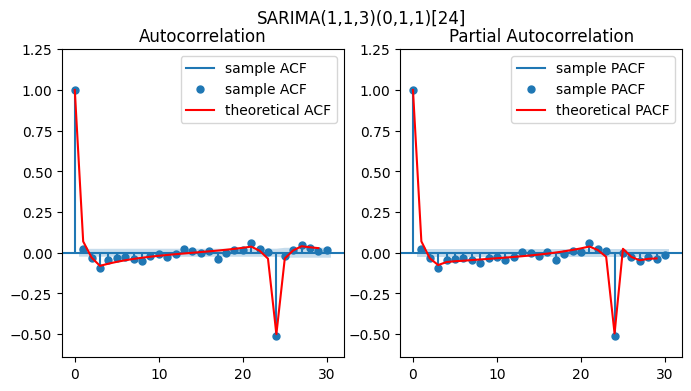

***************************
running (p,q,P,Q)=(1,3,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 3)x(1, 1, [], 24)   Log Likelihood              -16810.035
Date:                             Tue, 13 Feb 2024   AIC                          33632.071
Time:                                     03:25:39   BIC                          33672.795
Sample:                                 01-04-2022   HQIC                         33646.151
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8541      0.007    120.127      0.000       0.840       0.868
ma.L1         -0.8861      

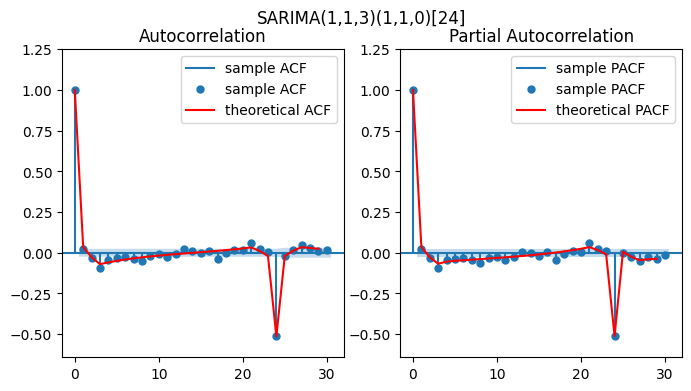

***************************
running (p,q,P,Q)=(1,3,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(1, 1, 3)x(1, 1, [1], 24)   Log Likelihood              -15854.444
Date:                              Tue, 13 Feb 2024   AIC                          31722.889
Time:                                      03:27:10   BIC                          31770.400
Sample:                                  01-04-2022   HQIC                         31739.315
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8441      0.009     92.189      0.000       0.826       0.862
ma.L1         -0.83

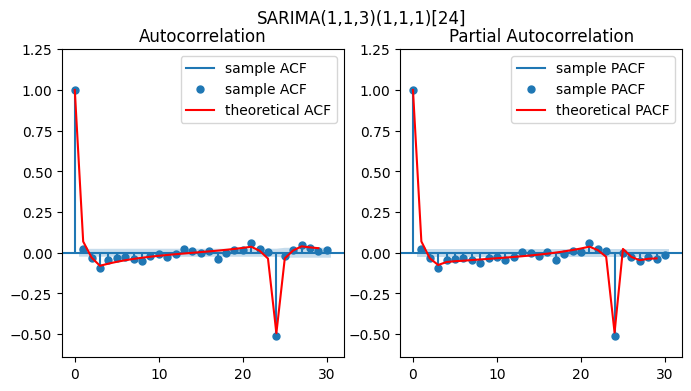

***************************
running (p,q,P,Q)=(2,0,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 24)   Log Likelihood              -18026.456
Date:                            Tue, 13 Feb 2024   AIC                          36058.911
Time:                                    03:27:13   BIC                          36079.273
Sample:                                01-04-2022   HQIC                         36065.951
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0232      0.008      2.955      0.003       0.008       0.039
ar.L2         -0.0355      0.010   

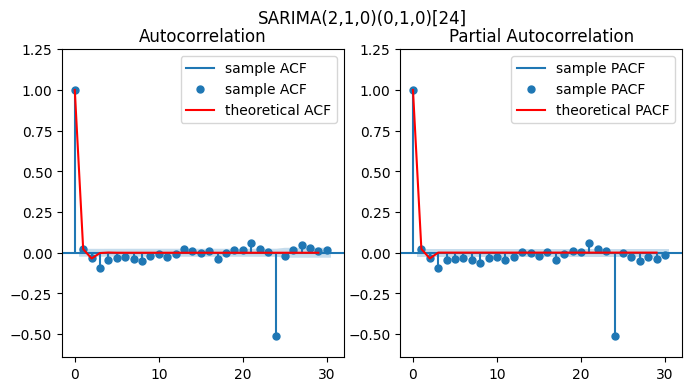

***************************
running (p,q,P,Q)=(2,0,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 24)   Log Likelihood              -16043.966
Date:                              Tue, 13 Feb 2024   AIC                          32095.932
Time:                                      03:27:33   BIC                          32123.082
Sample:                                  01-04-2022   HQIC                         32105.319
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0658      0.008      8.469      0.000       0.051       0.081
ar.L2         -0.04

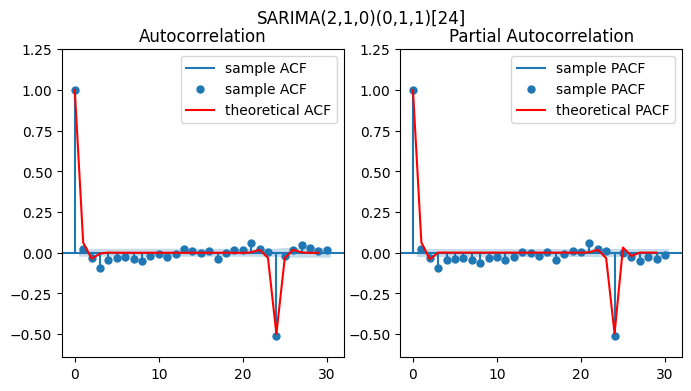

***************************
running (p,q,P,Q)=(2,0,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -17020.315
Date:                            Tue, 13 Feb 2024   AIC                          34048.630
Time:                                    03:27:46   BIC                          34075.780
Sample:                                01-04-2022   HQIC                         34058.017
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0315      0.008      3.853      0.000       0.015       0.048
ar.L2         -0.0328      0.011   

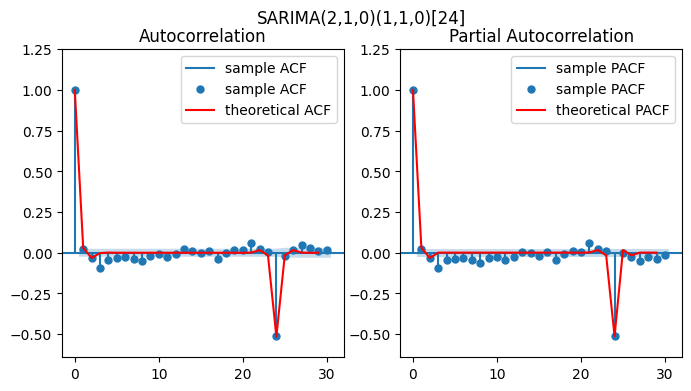

***************************
running (p,q,P,Q)=(2,0,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 24)   Log Likelihood              -16043.889
Date:                              Tue, 13 Feb 2024   AIC                          32097.778
Time:                                      03:28:17   BIC                          32131.715
Sample:                                  01-04-2022   HQIC                         32109.511
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0656      0.008      8.447      0.000       0.050       0.081
ar.L2         -0.04

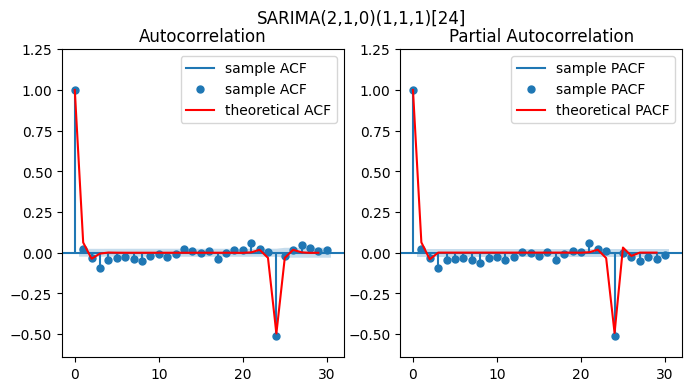

***************************
running (p,q,P,Q)=(2,1,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 24)   Log Likelihood              -17807.236
Date:                             Tue, 13 Feb 2024   AIC                          35622.472
Time:                                     03:28:57   BIC                          35649.621
Sample:                                 01-04-2022   HQIC                         35631.858
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9571      0.008    115.743      0.000       0.941       0.973
ar.L2         -0.0875      

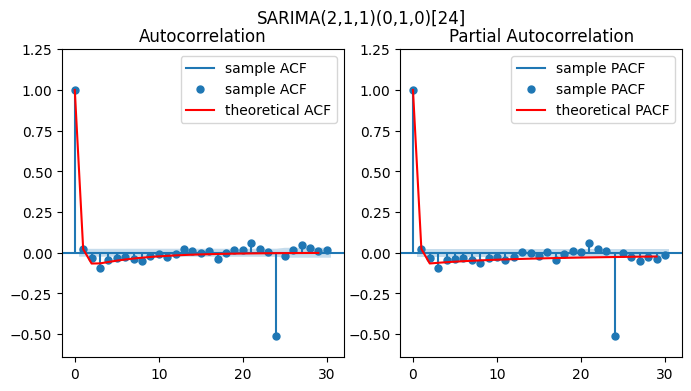

***************************
running (p,q,P,Q)=(2,1,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -15859.161
Date:                            Tue, 13 Feb 2024   AIC                          31728.321
Time:                                    03:30:13   BIC                          31762.258
Sample:                                01-04-2022   HQIC                         31740.054
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0020      0.009    116.725      0.000       0.985       1.019
ar.L2         -0.1251      0.008   

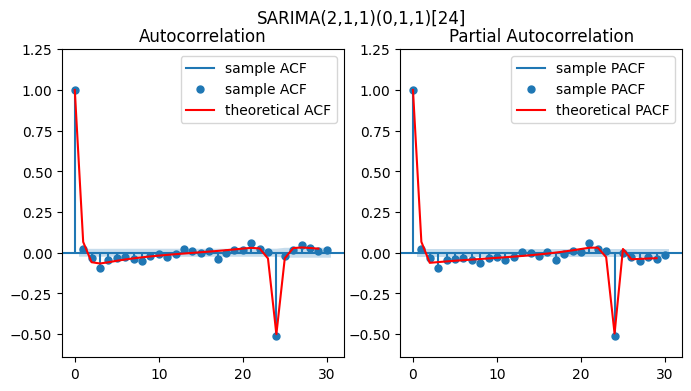

***************************
running (p,q,P,Q)=(2,1,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 24)   Log Likelihood              -16814.258
Date:                             Tue, 13 Feb 2024   AIC                          33638.516
Time:                                     03:32:01   BIC                          33672.453
Sample:                                 01-04-2022   HQIC                         33650.249
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9695      0.008    114.215      0.000       0.953       0.986
ar.L2         -0.0914      

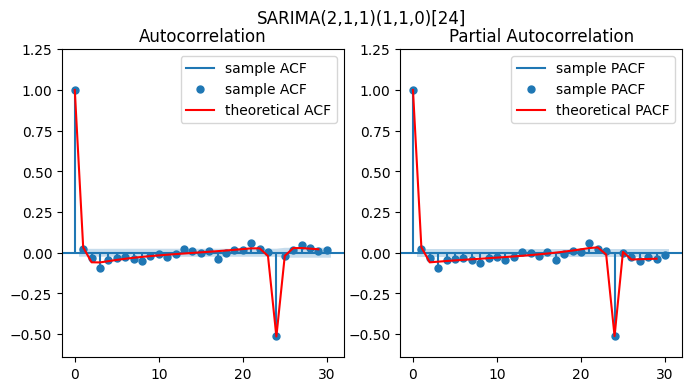

***************************
running (p,q,P,Q)=(2,1,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -15858.755
Date:                            Tue, 13 Feb 2024   AIC                          31729.510
Time:                                    03:33:27   BIC                          31770.234
Sample:                                01-04-2022   HQIC                         31743.589
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0017      0.009    116.924      0.000       0.985       1.018
ar.L2         -0.1245      0.008   

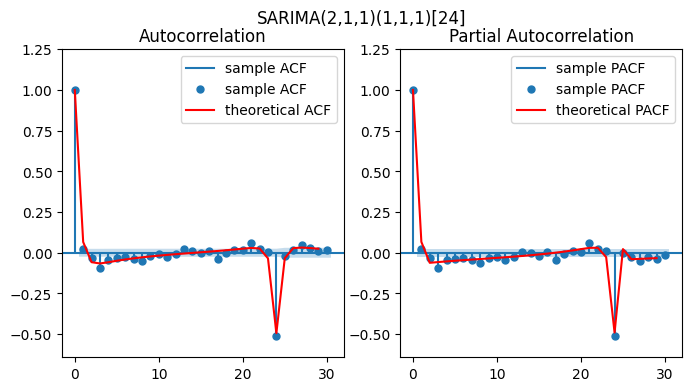

***************************
running (p,q,P,Q)=(2,2,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 24)   Log Likelihood              -17756.736
Date:                             Tue, 13 Feb 2024   AIC                          35523.472
Time:                                     03:34:15   BIC                          35557.408
Sample:                                 01-04-2022   HQIC                         35535.205
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0757      0.006    -13.598      0.000      -0.087      -0.065
ar.L2          0.8356      

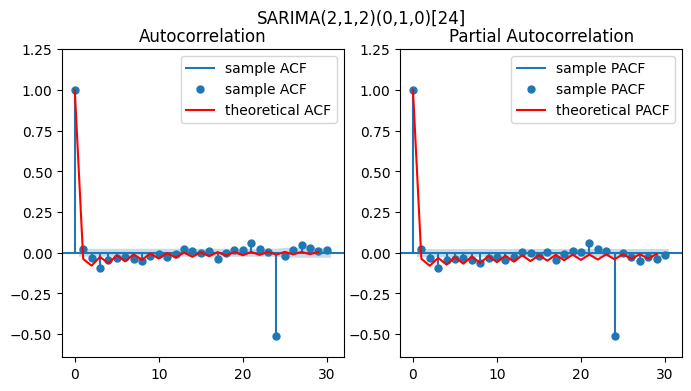

***************************
running (p,q,P,Q)=(2,2,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -15857.563
Date:                              Tue, 13 Feb 2024   AIC                          31727.125
Time:                                      03:35:36   BIC                          31767.849
Sample:                                  01-04-2022   HQIC                         31741.205
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1498      0.081     14.114      0.000       0.990       1.310
ar.L2         -0.25

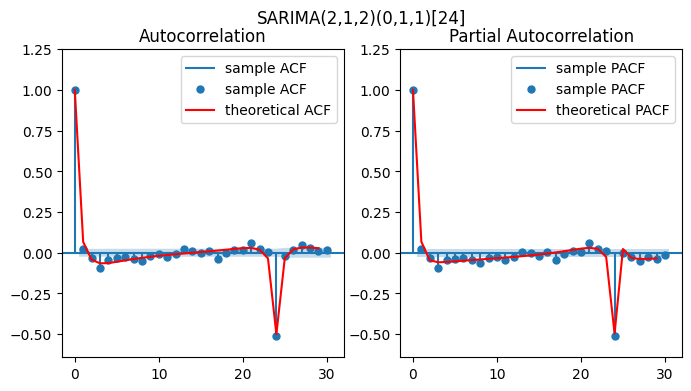

***************************
running (p,q,P,Q)=(2,2,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 24)   Log Likelihood              -16795.396
Date:                             Tue, 13 Feb 2024   AIC                          33602.792
Time:                                     03:38:13   BIC                          33643.516
Sample:                                 01-04-2022   HQIC                         33616.872
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0838      0.006    -15.063      0.000      -0.095      -0.073
ar.L2          0.8601      

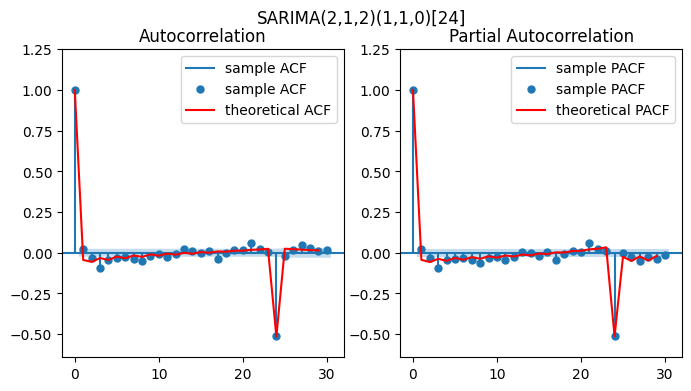

***************************
running (p,q,P,Q)=(2,2,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood              -15857.199
Date:                              Tue, 13 Feb 2024   AIC                          31728.397
Time:                                      03:39:42   BIC                          31775.909
Sample:                                  01-04-2022   HQIC                         31744.824
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1481      0.082     14.008      0.000       0.987       1.309
ar.L2         -0.25

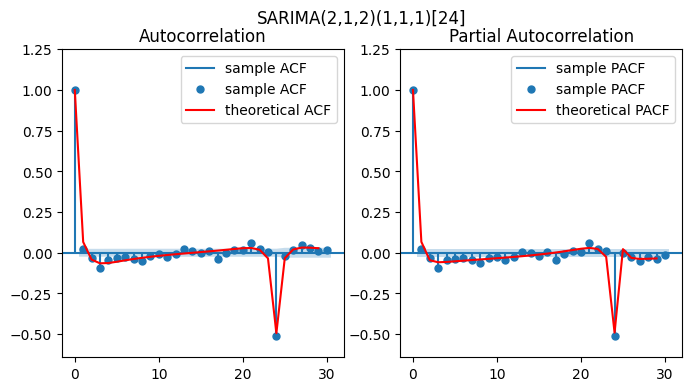

***************************
running (p,q,P,Q)=(2,3,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 24)   Log Likelihood              -17744.446
Date:                             Tue, 13 Feb 2024   AIC                          35500.892
Time:                                     03:40:50   BIC                          35541.616
Sample:                                 01-04-2022   HQIC                         35514.972
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0961      0.007    -14.301      0.000      -0.109      -0.083
ar.L2          0.8264      

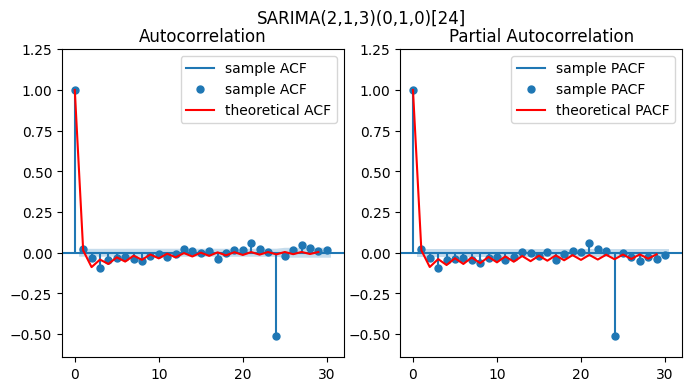

***************************
running (p,q,P,Q)=(2,3,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 24)   Log Likelihood              -15852.694
Date:                              Tue, 13 Feb 2024   AIC                          31719.389
Time:                                      03:42:29   BIC                          31766.900
Sample:                                  01-04-2022   HQIC                         31735.815
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4679      0.142      3.296      0.001       0.190       0.746
ar.L2          0.32

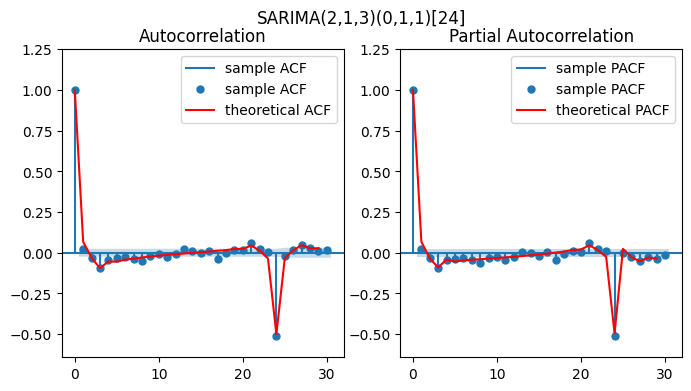

***************************
running (p,q,P,Q)=(2,3,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 24)   Log Likelihood              -16777.715
Date:                             Tue, 13 Feb 2024   AIC                          33569.429
Time:                                     03:45:49   BIC                          33616.941
Sample:                                 01-04-2022   HQIC                         33585.856
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1046      0.007    -15.767      0.000      -0.118      -0.092
ar.L2          0.8478      

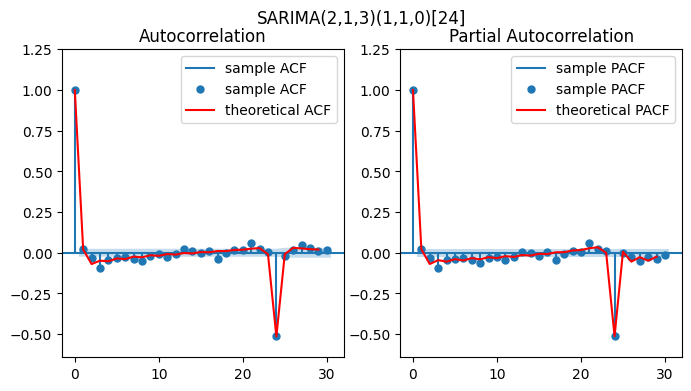

***************************
running (p,q,P,Q)=(2,3,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood              -15852.316
Date:                              Tue, 13 Feb 2024   AIC                          31720.631
Time:                                      03:48:04   BIC                          31774.930
Sample:                                  01-04-2022   HQIC                         31739.404
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4661      0.143      3.271      0.001       0.187       0.745
ar.L2          0.32

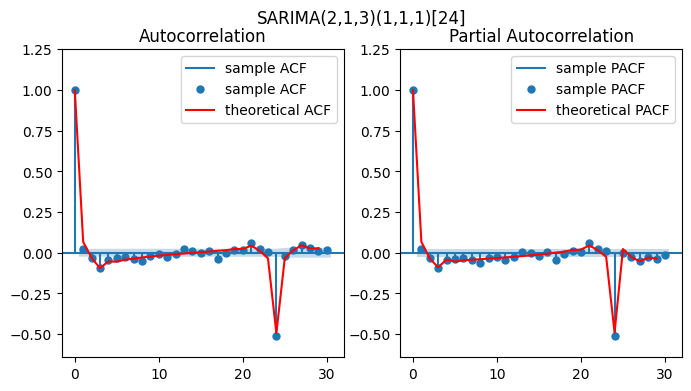

***************************
running (p,q,P,Q)=(3,0,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 0)x(0, 1, 0, 24)   Log Likelihood              -17998.735
Date:                            Tue, 13 Feb 2024   AIC                          36005.470
Time:                                    03:48:08   BIC                          36032.620
Sample:                                01-04-2022   HQIC                         36014.857
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0199      0.008      2.531      0.011       0.004       0.035
ar.L2         -0.0334      0.011   

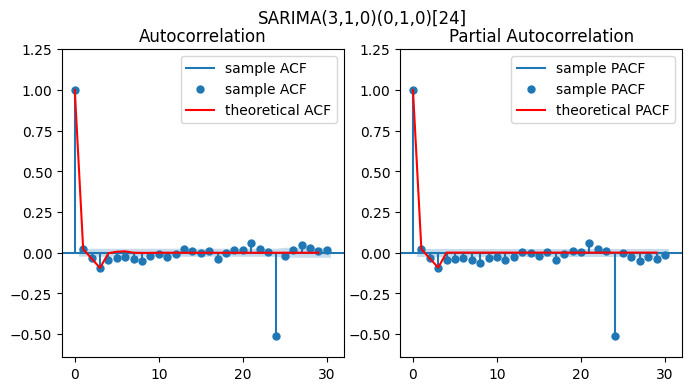

***************************
running (p,q,P,Q)=(3,0,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 0)x(0, 1, [1], 24)   Log Likelihood              -16014.964
Date:                              Tue, 13 Feb 2024   AIC                          32039.928
Time:                                      03:48:36   BIC                          32073.865
Sample:                                  01-04-2022   HQIC                         32051.662
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0622      0.008      8.022      0.000       0.047       0.077
ar.L2         -0.03

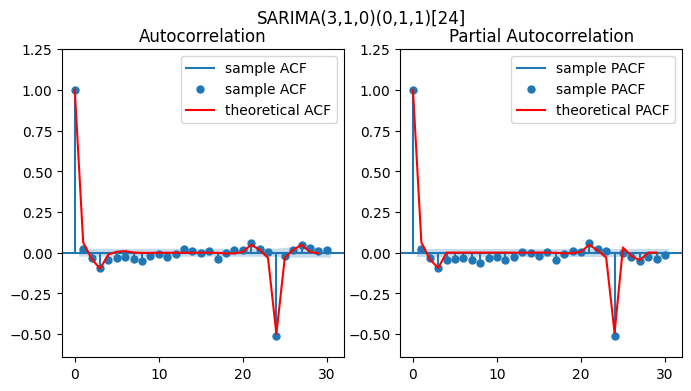

***************************
running (p,q,P,Q)=(3,0,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -16998.296
Date:                            Tue, 13 Feb 2024   AIC                          34006.593
Time:                                    03:48:48   BIC                          34040.529
Sample:                                01-04-2022   HQIC                         34018.326
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0288      0.008      3.512      0.000       0.013       0.045
ar.L2         -0.0302      0.011   

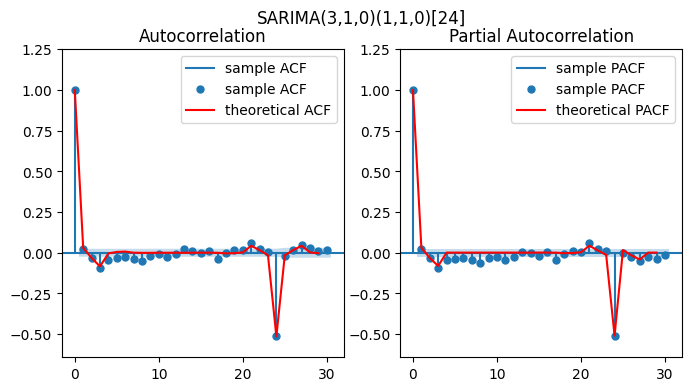

***************************
running (p,q,P,Q)=(3,0,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 0)x(1, 1, [1], 24)   Log Likelihood              -16014.865
Date:                              Tue, 13 Feb 2024   AIC                          32041.729
Time:                                      03:49:23   BIC                          32082.454
Sample:                                  01-04-2022   HQIC                         32055.809
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0620      0.008      7.995      0.000       0.047       0.077
ar.L2         -0.03

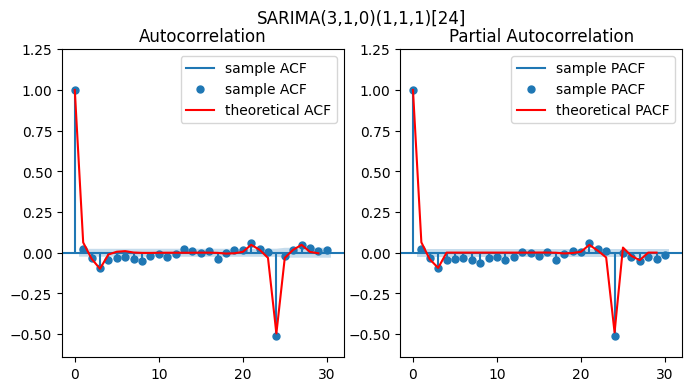

***************************
running (p,q,P,Q)=(3,1,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 24)   Log Likelihood              -17803.592
Date:                             Tue, 13 Feb 2024   AIC                          35617.184
Time:                                     03:50:05   BIC                          35651.120
Sample:                                 01-04-2022   HQIC                         35628.917
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9542      0.008    115.663      0.000       0.938       0.970
ar.L2         -0.0556      

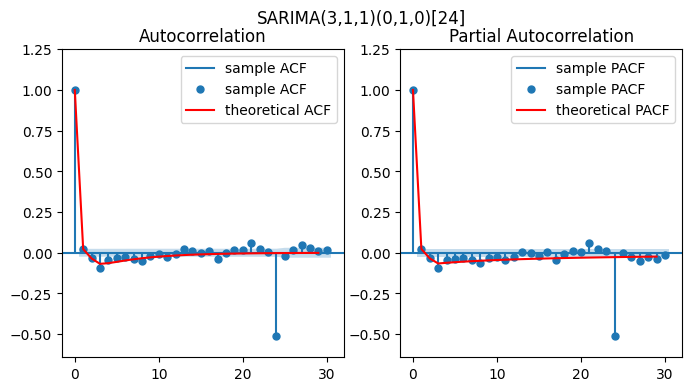

***************************
running (p,q,P,Q)=(3,1,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -15856.826
Date:                            Tue, 13 Feb 2024   AIC                          31725.653
Time:                                    03:51:34   BIC                          31766.377
Sample:                                01-04-2022   HQIC                         31739.732
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9970      0.009    116.271      0.000       0.980       1.014
ar.L2         -0.0990      0.012   

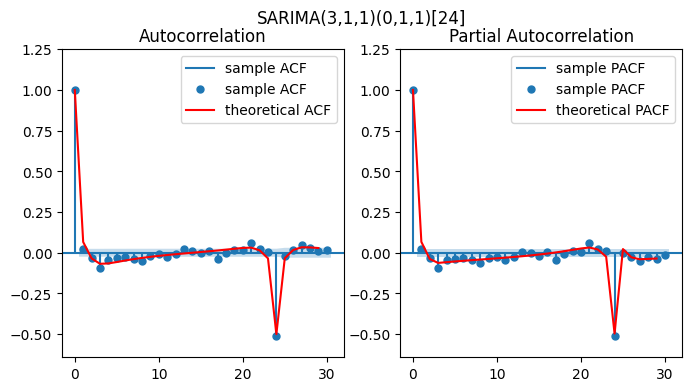

***************************
running (p,q,P,Q)=(3,1,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 1)x(1, 1, [], 24)   Log Likelihood              -16810.890
Date:                             Tue, 13 Feb 2024   AIC                          33633.780
Time:                                     03:53:25   BIC                          33674.504
Sample:                                 01-04-2022   HQIC                         33647.860
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9667      0.008    113.920      0.000       0.950       0.983
ar.L2         -0.0607      

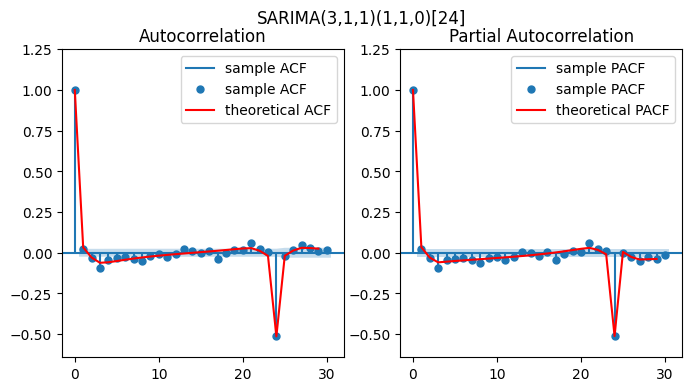

***************************
running (p,q,P,Q)=(3,1,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -15856.469
Date:                            Tue, 13 Feb 2024   AIC                          31726.937
Time:                                    03:55:11   BIC                          31774.449
Sample:                                01-04-2022   HQIC                         31743.364
                                     - 10-04-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9969      0.009    116.478      0.000       0.980       1.014
ar.L2         -0.0986      0.012   

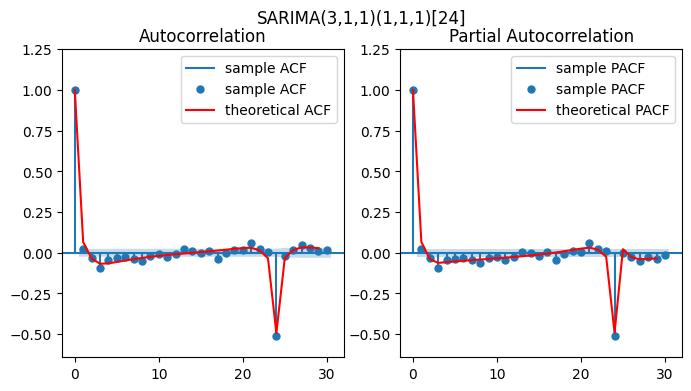

***************************
running (p,q,P,Q)=(3,2,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 2)x(0, 1, [], 24)   Log Likelihood              -17742.669
Date:                             Tue, 13 Feb 2024   AIC                          35497.338
Time:                                     03:56:12   BIC                          35538.062
Sample:                                 01-04-2022   HQIC                         35511.418
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0209      0.008     -2.535      0.011      -0.037      -0.005
ar.L2          0.8307      

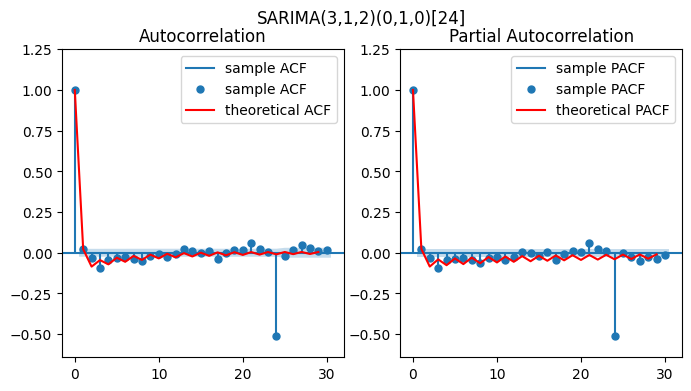

***************************
running (p,q,P,Q)=(3,2,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -15853.978
Date:                              Tue, 13 Feb 2024   AIC                          31721.957
Time:                                      03:58:03   BIC                          31769.468
Sample:                                  01-04-2022   HQIC                         31738.383
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4526      0.171      2.645      0.008       0.117       0.788
ar.L2          0.45

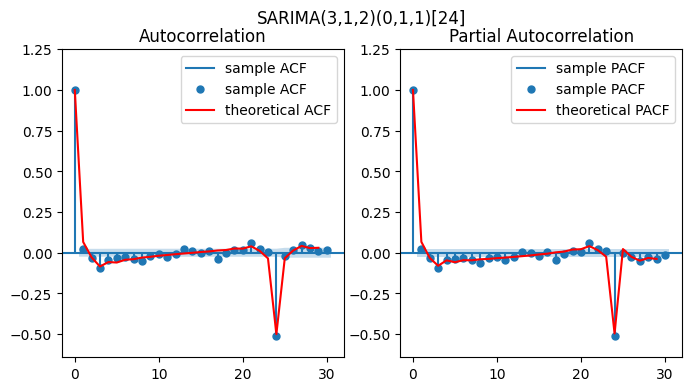

***************************
running (p,q,P,Q)=(3,2,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 2)x(1, 1, [], 24)   Log Likelihood              -16775.608
Date:                             Tue, 13 Feb 2024   AIC                          33565.217
Time:                                     04:00:58   BIC                          33612.729
Sample:                                 01-04-2022   HQIC                         33581.643
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0171      0.008     -2.017      0.044      -0.034      -0.000
ar.L2          0.8538      

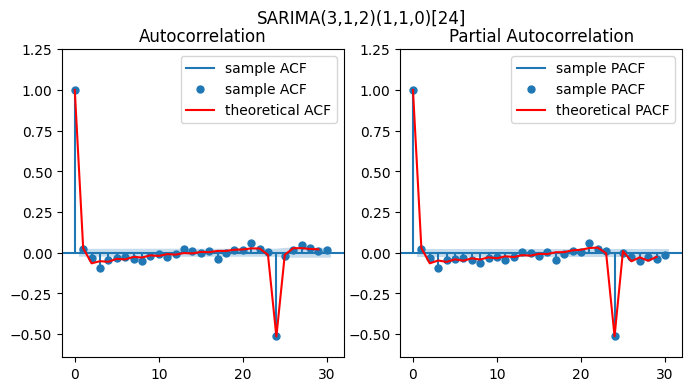

***************************
running (p,q,P,Q)=(3,2,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 24)   Log Likelihood              -15853.613
Date:                              Tue, 13 Feb 2024   AIC                          31723.225
Time:                                      04:04:23   BIC                          31777.524
Sample:                                  01-04-2022   HQIC                         31741.999
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4508      0.172      2.625      0.009       0.114       0.787
ar.L2          0.45

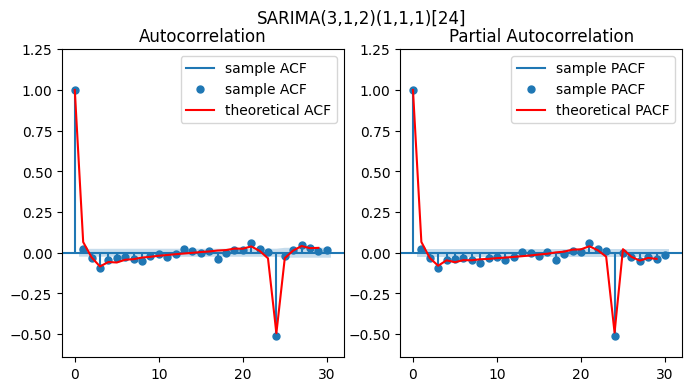

***************************
running (p,q,P,Q)=(3,3,0,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 24)   Log Likelihood              -17800.752
Date:                             Tue, 13 Feb 2024   AIC                          35615.504
Time:                                     04:05:43   BIC                          35663.016
Sample:                                 01-04-2022   HQIC                         35631.931
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4933      0.176      2.798      0.005       0.148       0.839
ar.L2          0.2250      

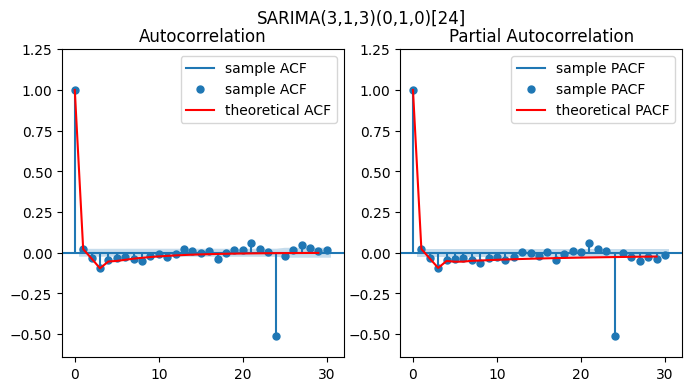

***************************
running (p,q,P,Q)=(3,3,0,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 24)   Log Likelihood              -15852.251
Date:                              Tue, 13 Feb 2024   AIC                          31720.502
Time:                                      04:08:16   BIC                          31774.801
Sample:                                  01-04-2022   HQIC                         31739.275
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5868      0.164      3.568      0.000       0.264       0.909
ar.L2          0.10

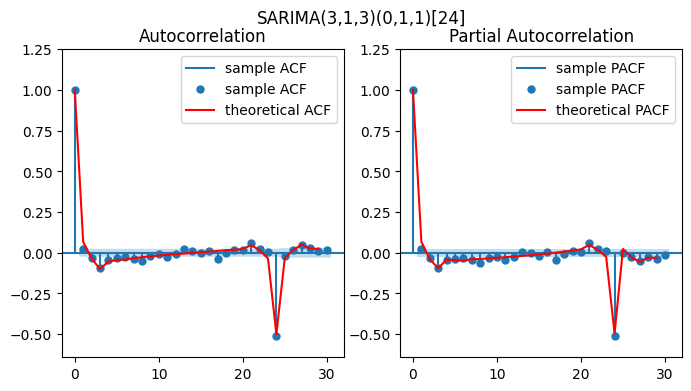

***************************
running (p,q,P,Q)=(3,3,1,0)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 3)x(1, 1, [], 24)   Log Likelihood              -16778.692
Date:                             Tue, 13 Feb 2024   AIC                          33573.384
Time:                                     04:11:37   BIC                          33627.683
Sample:                                 01-04-2022   HQIC                         33592.157
                                      - 10-04-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6737      0.057     11.718      0.000       0.561       0.786
ar.L2          0.9095      

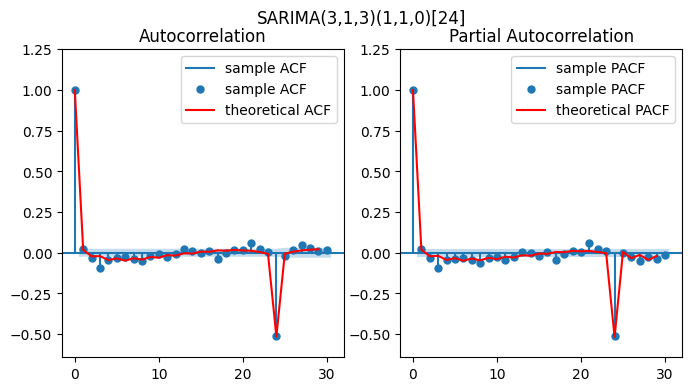

***************************
running (p,q,P,Q)=(3,3,1,1)
***************************


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 6576
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 24)   Log Likelihood              -15851.848
Date:                              Tue, 13 Feb 2024   AIC                          31721.697
Time:                                      04:14:26   BIC                          31782.783
Sample:                                  01-04-2022   HQIC                         31742.816
                                       - 10-04-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5916      0.165      3.576      0.000       0.267       0.916
ar.L2          0.09

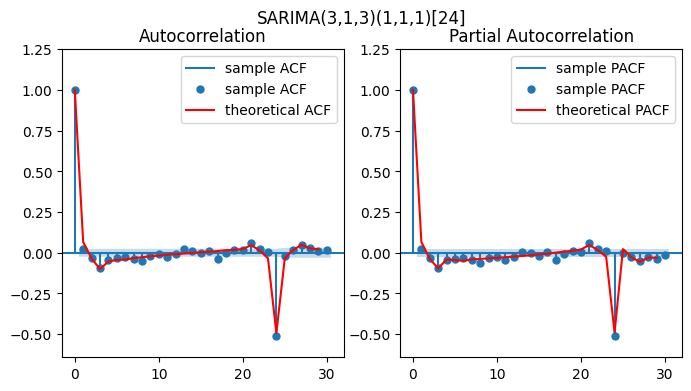

***************************


In [77]:
sarima_search_list = []
# usually, the seasonal order should not larger than 1
for p in range(0,4):
  for q in range(0,4):
    for P in range(0,2):
      for Q in range(0,2):
        print('running (p,q,P,Q)=(%s,%s,%s,%s)' % (p,q,P,Q))
        try:
          print("***************************")
          df = searching_sarima(train_data, p, q, P, Q,test_data, show_result=True)
          print("***************************")
          sarima_search_list.append(df)
        except:
          print('the process is not feasible: (p,q,P,Q)=(%s,%s,%s,%s)' % (p,q,P,Q))


sarima_search_df = pd.DataFrame(sarima_search_list)

In [85]:
sarima_search_df

p  q  P  Q           AIC          AICc           BIC    test_mse
0   0  0  0  0  36066.471985  36066.472596  36073.259358  111.782723
1   0  0  0  1  32128.665656  32128.667489  32142.240402    2.967451
2   0  0  1  0  34057.778454  34057.780287  34071.353200    9.956886
3   0  0  1  1  32130.328454  32130.332120  32150.690573    2.986919
4   0  1  0  0  36064.965342  36064.967175  36078.540088  111.825385
.. .. .. .. ..           ...           ...           ...         ...
59  3  2  1  1  31723.225453  31723.247465  31777.524437    4.859476
60  3  3  0  0  35615.504345  35615.521463  35663.015956    1.150279
61  3  3  0  1  31720.502396  31720.524407  31774.801380    5.008920
62  3  3  1  0  33573.384113  33573.406125  33627.683097    0.809797
63  3  3  1  1  31721.696632  31721.724151  31782.782989    5.004456

[64 rows x 8 columns]

Note that some model has lower AIC but with higher test_mse, they may show better fit with the training data, but worse to predict the future.

To balance the 2 metrics, we may first consider lower test_mse as possible, then choose the model with lower AIC.

In [87]:
sarima_search_df.sort_values('AIC').head(30)

p  q  P  Q           AIC          AICc           BIC  test_mse
45  2  3  0  1  31719.388730  31719.405847  31766.900341  4.925965
61  3  3  0  1  31720.502396  31720.524407  31774.801380  5.008920
47  2  3  1  1  31720.631077  31720.653088  31774.930061  4.922681
29  1  3  0  1  31721.601826  31721.614662  31762.326064  4.840363
63  3  3  1  1  31721.696632  31721.724151  31782.782989  5.004456
57  3  2  0  1  31721.956756  31721.973874  31769.468367  4.860936
31  1  3  1  1  31722.888569  31722.905686  31770.400180  4.837837
59  3  2  1  1  31723.225453  31723.247465  31777.524437  4.859476
53  3  1  0  1  31725.652545  31725.665381  31766.376783  4.828934
55  3  1  1  1  31726.937348  31726.954466  31774.448959  4.829491
41  2  2  0  1  31727.125070  31727.137907  31767.849308  4.859238
37  2  1  0  1  31728.321023  31728.330190  31762.257888  5.007659
43  2  2  1  1  31728.397431  31728.414549  31775.909042  4.859585
39  2  1  1  1  31729.509626  31729.522463  31770.233864  5.004490
25  1  2  0  1  31736.239076  31736.248243  31770.175941  5.217218
27  1  2  1  1  31737.280253  31737.293089  31778.004491  5.233776
13  0  3  0  1  32034.034760  32034.043927  32067.971625  2.324732
15  0  3  1  1  32035.816008  32035.828844  32076.540246  2.334000
49  3  0  0  1  32039.928451  32039.937619  32073.865316  2.450133
51  3  0  1  1  32041.729329  32041.742166  32082.453567  2.461210
33  2  0  0  1  32095.932255  32095.938365  32123.081747  2.858567
35  2  0  1  1  32097.778127  32097.787294  32131.714992  2.870966
9   0  2  0  1  32100.671284  32100.677395  32127.820776  2.911332
11  0  2  1  1  32102.508580  32102.517747  32136.445445  2.923963
5   0  1  0  1  32103.018176  32103.021842  32123.380295  3.029158
21  1  1  0  1  32103.961641  32103.967751  32131.111133  3.003688
17  1  0  0  1  32104.826368  32104.830034  32125.188487  3.044263
7   0  1  1  1  32104.889401  32104.895512  32132.038893  3.040932
23  1  1  1  1  32105.827564  32105.836731  32139.764429  3.016881
19  1  0  1  1  32106.690423  32106.696534  32133.839915  3.056414

In [91]:
sarima_search_df.sort_values('test_mse').head(30)

p  q  P  Q           AIC          AICc           BIC  test_mse
62  3  3  1  0  33573.384113  33573.406125  33627.683097  0.809797
42  2  2  1  0  33602.792024  33602.804860  33643.516262  0.827376
46  2  3  1  0  33569.429443  33569.446561  33616.941054  0.857499
58  3  2  1  0  33565.216892  33565.234010  33612.728503  0.863568
26  1  2  1  0  33642.872046  33642.881213  33676.808911  0.872422
38  2  1  1  0  33638.516250  33638.525417  33672.453114  0.879598
54  3  1  1  0  33633.780043  33633.792880  33674.504281  0.889864
30  1  3  1  0  33632.070983  33632.083819  33672.795221  0.896520
52  3  1  0  0  35617.183514  35617.192681  35651.120379  1.146742
60  3  3  0  0  35615.504345  35615.521463  35663.015956  1.150279
28  1  3  0  0  35614.716242  35614.725409  35648.653107  1.151719
36  2  1  0  0  35622.471895  35622.478006  35649.621387  1.176635
56  3  2  0  0  35497.337775  35497.350611  35538.062013  1.192748
24  1  2  0  0  35626.648455  35626.654566  35653.797947  1.194207
44  2  3  0  0  35500.892146  35500.904982  35541.616384  1.210898
40  2  2  0  0  35523.471520  35523.480687  35557.408385  1.316434
13  0  3  0  1  32034.034760  32034.043927  32067.971625  2.324732
15  0  3  1  1  32035.816008  32035.828844  32076.540246  2.334000
49  3  0  0  1  32039.928451  32039.937619  32073.865316  2.450133
51  3  0  1  1  32041.729329  32041.742166  32082.453567  2.461210
33  2  0  0  1  32095.932255  32095.938365  32123.081747  2.858567
35  2  0  1  1  32097.778127  32097.787294  32131.714992  2.870966
9   0  2  0  1  32100.671284  32100.677395  32127.820776  2.911332
11  0  2  1  1  32102.508580  32102.517747  32136.445445  2.923963
1   0  0  0  1  32128.665656  32128.667489  32142.240402  2.967451
3   0  0  1  1  32130.328454  32130.332120  32150.690573  2.986919
21  1  1  0  1  32103.961641  32103.967751  32131.111133  3.003688
23  1  1  1  1  32105.827564  32105.836731  32139.764429  3.016881
5   0  1  0  1  32103.018176  32103.021842  32123.380295  3.029158
7   0  1  1  1  32104.889401  32104.895512  32132.038893  3.040932

We can see that some model can have test_mse is below 1. Again as we emphazise, we should always seek for parsimonious model.

Some model may worth pointing out:


index=62: ARIMA(3,1,3)(1,1,0)[24] has the lowest test_mse, we wish to find a model that have similar or just slightly larger AIC but have less parameters.

index=26: ARIMA(1,1,2)(1,1,0)[24] has quite a few parameters with low test_mse and AIC not increases a lot (about 70)

index=38: ARIMA(2,1,1)(1,1,0)[24] similar to the above

imdex=54: ARIMA(3,1,1)(1,1,0)[24] similar to the above

index=30: ARIMA(1,1,3)(1,1,0)[24] similarly, this it is the type using ARIMA(1,1,3) but this time contains seasonal differencing and extra AR component



p.s. We cannot compare the AIC with **different differencing order**, we cannot just comparing the AIC with ARIMA and SARIMA

In [98]:
# df with p,q,P,Q (as we used 1 seasonal order differencing)
# plot together with the previous results

def forecast_plot2(pq_df, pqPQ_df, train_data, test_data):

  plt.figure(figsize=(14,10))
  plt.ylim(-5,45)
  plt.plot(train_data[-200:], color='black', label="train_data")
  plt.plot(test_data, color='blue', label="test_data")
  colors = ['red','green','brown', 'purple', 'yellow', 'pink', 'gray', 'olive', 'navy', 'teal', 'aqua']
  for i in range(pq_df.shape[0]):
    print(pq_df.loc[i])
    p = p_q_pairs_df.iloc[i, 0]
    q = p_q_pairs_df.iloc[i, 1]

    model = ARIMA(train_data, order=(p, 1, q), enforce_stationarity=True, enforce_invertibility=True)
    result = model.fit()
    prediction = result.get_forecast(steps=test_data.shape[0])
    prediction = pd.concat((prediction.predicted_mean, prediction.conf_int(alpha=0.05)), axis=1)

    color = colors[i]
    plt.plot(prediction['predicted_mean'], color=color, label='ARIMA(%s,1,%s) forecast' % (p,q))
    plt.plot(prediction['lower temperature'], color=color, linestyle='--', label='ARIMA(%s,1,%s) 95 Bound' % (p,q))
    plt.plot(prediction['upper temperature'], color=color, linestyle='--')

  for j in range(pqPQ_df.shape[0]):
    print(pqPQ_df.loc[j])
    p = pqPQ_df.iloc[j, 0]
    q = pqPQ_df.iloc[j, 1]
    P = pqPQ_df.iloc[j, 2]
    Q = pqPQ_df.iloc[j, 3]

    model = SARIMAX(train_data, order=(p, 1, q), seasonal_order=(P,1,Q,24), enforce_stationarity=True, enforce_invertibility=True)
    result = model.fit()
    prediction = result.get_forecast(steps=test_data.shape[0])
    prediction = pd.concat((prediction.predicted_mean, prediction.conf_int(alpha=0.05)), axis=1)

    color = colors[pq_df.shape[0]+j]
    plt.plot(prediction['predicted_mean'], color=color, label='ARIMA(%s,1,%s)(%s,1,%s)[24] forecast' % (p,q,P,Q))
    plt.plot(prediction['lower temperature'], color=color, linestyle='--', label='ARIMA(%s,1,%s)(%s,1,%s)[24] 95 Bound' % (p,q,P,Q))
    plt.plot(prediction['upper temperature'], color=color, linestyle='--')



  plt.legend()
  plt.show()



In [99]:
p_q_P_Q_pairs_df = pd.DataFrame(columns=['p', 'q', 'P', 'Q'])
p_q_P_Q_pairs_df.loc[0] = [3,3,1,0]
p_q_P_Q_pairs_df.loc[1] = [1,2,1,0]
p_q_P_Q_pairs_df.loc[2] = [2,1,1,0]
p_q_P_Q_pairs_df.loc[3] = [3,1,1,0]
p_q_P_Q_pairs_df.loc[4] = [1,3,1,0]

p_q_P_Q_pairs_df

p  q  P  Q
0  3  3  1  0
1  1  2  1  0
2  2  1  1  0
3  3  1  1  0
4  1  3  1  0

p    2
q    1
Name: 0, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

p    1
q    3
Name: 1, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p    1
q    2
Name: 2, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


p    0
q    3
Name: 3, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


p    3
q    3
P    1
Q    0
Name: 0, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p    1
q    2
P    1
Q    0
Name: 1, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


p    2
q    1
P    1
Q    0
Name: 2, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p    3
q    1
P    1
Q    0
Name: 3, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


p    1
q    3
P    1
Q    0
Name: 4, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


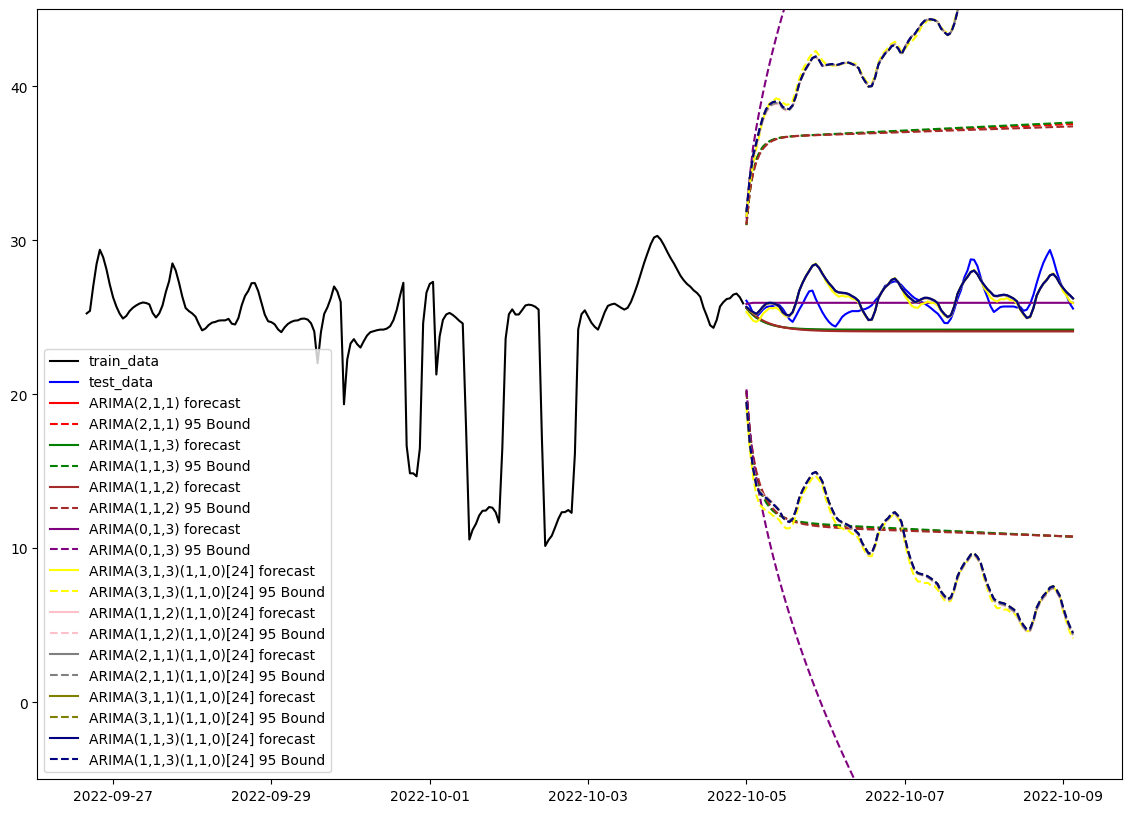

In [100]:
forecast_plot2(p_q_pairs_df, p_q_P_Q_pairs_df, train_data, test_data)